# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

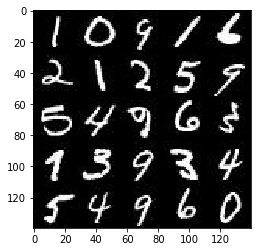

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

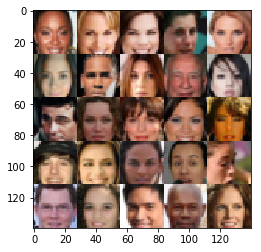

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, 
                                shape=(None, image_width, image_height, image_channels),
                                name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha*x,x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = leaky_relu(conv_layer1)
        
        conv_layer2 = tf.layers.conv2d(conv_layer1, 128, 5, strides=2, padding='same')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=True)
        relu2 = leaky_relu(conv_layer2)
        
        conv_layer3 = tf.layers.conv2d(conv_layer2, 256, 5, strides=2, padding='same')
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training=True)
        relu3 = leaky_relu(conv_layer3)
        
        conv_layer4 = tf.layers.conv2d(conv_layer3, 512, 5, strides=2, padding='same')
        conv_layer4 = tf.layers.batch_normalization(conv_layer4)
        relu4 = leaky_relu(conv_layer4)
        
        #Flat
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        #Logits
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        #Fully connected layer
        fully_conn = tf.layers.dense(z, 7*7*512)
        fully_conn = tf.reshape(fully_conn, (-1,7,7,512))
        fully_conn = tf.layers.batch_normalization(fully_conn, training=is_train)
        fully_conn = leaky_relu(fully_conn)
        # 7x7x512

        #Convolutions
        conv_layer1 = tf.layers.conv2d_transpose(fully_conn, 256, 3, strides=2, padding='same')
        conv_layer1 = tf.layers.batch_normalization(conv_layer1, training=is_train)
        conv_layer1 = leaky_relu(conv_layer1)
        # 14x14x256

        conv_layer2 = tf.layers.conv2d_transpose(conv_layer1, 128, 3, strides=1, padding='same')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=is_train)
        conv_layer2 = leaky_relu(conv_layer2)
        # 14x14x128

        conv_layer3 = tf.layers.conv2d_transpose(conv_layer2, 64, 3, strides=2, padding='same')
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training=is_train)
        conv_layer3 = leaky_relu(conv_layer3)
        # 28x28x64   

        # Output layer
        logits = tf.layers.conv2d_transpose(conv_layer3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_dim 

        gen_out = tf.tanh(logits)

    return gen_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Label smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=(tf.ones_like(d_model_real)*(1-smooth)) ))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))

    dicriminator_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    
    return dicriminator_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("Shape:", data_shape)
    print("Learning rate:", learning_rate)
    img_width = data_shape[1]
    img_height = data_shape[2]
    img_channels = data_shape[3]
    
    # Init GAN
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    print(input_real)
    print(input_z)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Train
    steps = 0
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #adjust the range
                batch_images *= 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 5 == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(d_loss_train),
                         "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Shape: (60000, 28, 28, 1)
Learning rate: 0.0002
Tensor("input_real:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("input_z:0", shape=(?, 128), dtype=float32)
Epoch 1/3... Discriminator Loss: 4.7659... Generator Loss: 0.0188
Epoch 1/3... Discriminator Loss: 4.4947... Generator Loss: 0.0233
Epoch 1/3... Discriminator Loss: 0.4027... Generator Loss: 3.8965
Epoch 1/3... Discriminator Loss: 2.2853... Generator Loss: 0.1931
Epoch 1/3... Discriminator Loss: 0.9760... Generator Loss: 0.9237
Epoch 1/3... Discriminator Loss: 0.7341... Generator Loss: 1.2439
Epoch 1/3... Discriminator Loss: 0.4050... Generator Loss: 2.9258
Epoch 1/3... Discriminator Loss: 0.3604... Generator Loss: 7.8796
Epoch 1/3... Discriminator Loss: 0.3446... Generator Loss: 6.7756
Epoch 1/3... Discriminator Loss: 0.3490... Generator Loss: 4.7021
Epoch 1/3... Discriminator Loss: 0.3380... Generator Loss: 7.8943
Epoch 1/3... Discriminator Loss: 0.4240... Generator Loss: 2.8741
Epoch 1/3... Discriminator Loss: 0.4304... Genera

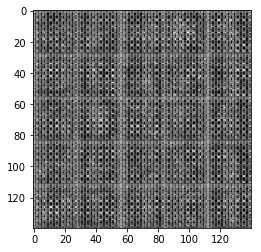

Epoch 1/3... Discriminator Loss: 0.3845... Generator Loss: 3.1943
Epoch 1/3... Discriminator Loss: 0.3818... Generator Loss: 3.3568
Epoch 1/3... Discriminator Loss: 0.3741... Generator Loss: 3.3084
Epoch 1/3... Discriminator Loss: 0.3626... Generator Loss: 3.6717
Epoch 1/3... Discriminator Loss: 0.3694... Generator Loss: 3.4024
Epoch 1/3... Discriminator Loss: 1.9536... Generator Loss: 0.3407
Epoch 1/3... Discriminator Loss: 2.5141... Generator Loss: 0.3181
Epoch 1/3... Discriminator Loss: 1.0397... Generator Loss: 1.4639
Epoch 1/3... Discriminator Loss: 2.4058... Generator Loss: 0.1648
Epoch 1/3... Discriminator Loss: 1.2593... Generator Loss: 0.8625
Epoch 1/3... Discriminator Loss: 2.3735... Generator Loss: 2.0108
Epoch 1/3... Discriminator Loss: 1.0118... Generator Loss: 1.0695
Epoch 1/3... Discriminator Loss: 1.5564... Generator Loss: 0.7025
Epoch 1/3... Discriminator Loss: 1.2587... Generator Loss: 0.6891
Epoch 1/3... Discriminator Loss: 1.1658... Generator Loss: 1.2454
Epoch 1/3.

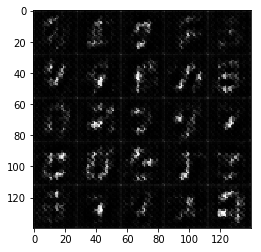

Epoch 1/3... Discriminator Loss: 1.4971... Generator Loss: 0.6613
Epoch 1/3... Discriminator Loss: 1.4134... Generator Loss: 0.6461
Epoch 1/3... Discriminator Loss: 1.5186... Generator Loss: 1.1097
Epoch 1/3... Discriminator Loss: 1.4151... Generator Loss: 0.6535
Epoch 1/3... Discriminator Loss: 1.5168... Generator Loss: 0.6121
Epoch 1/3... Discriminator Loss: 1.5880... Generator Loss: 0.5163
Epoch 1/3... Discriminator Loss: 1.5745... Generator Loss: 0.5369
Epoch 1/3... Discriminator Loss: 1.3387... Generator Loss: 0.8179
Epoch 1/3... Discriminator Loss: 1.3308... Generator Loss: 0.9531
Epoch 1/3... Discriminator Loss: 1.4325... Generator Loss: 0.6782
Epoch 1/3... Discriminator Loss: 1.4776... Generator Loss: 0.9106
Epoch 1/3... Discriminator Loss: 1.4483... Generator Loss: 0.8055
Epoch 1/3... Discriminator Loss: 1.3740... Generator Loss: 0.7570
Epoch 1/3... Discriminator Loss: 1.4544... Generator Loss: 0.9056
Epoch 1/3... Discriminator Loss: 1.4018... Generator Loss: 0.8191
Epoch 1/3.

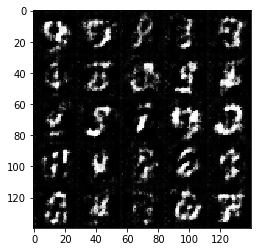

Epoch 1/3... Discriminator Loss: 1.3057... Generator Loss: 0.7758
Epoch 1/3... Discriminator Loss: 1.3704... Generator Loss: 0.8114
Epoch 1/3... Discriminator Loss: 1.4318... Generator Loss: 0.7901
Epoch 1/3... Discriminator Loss: 1.2055... Generator Loss: 0.8604
Epoch 1/3... Discriminator Loss: 1.4201... Generator Loss: 0.6619
Epoch 1/3... Discriminator Loss: 1.5538... Generator Loss: 0.5477
Epoch 1/3... Discriminator Loss: 1.3319... Generator Loss: 0.7572
Epoch 1/3... Discriminator Loss: 1.3438... Generator Loss: 0.7505
Epoch 1/3... Discriminator Loss: 1.5113... Generator Loss: 0.8267
Epoch 1/3... Discriminator Loss: 1.3558... Generator Loss: 0.9177
Epoch 1/3... Discriminator Loss: 1.3990... Generator Loss: 0.8248
Epoch 1/3... Discriminator Loss: 1.3395... Generator Loss: 0.8285
Epoch 1/3... Discriminator Loss: 1.2768... Generator Loss: 0.7980
Epoch 1/3... Discriminator Loss: 1.2935... Generator Loss: 0.7164
Epoch 1/3... Discriminator Loss: 1.3798... Generator Loss: 0.6853
Epoch 1/3.

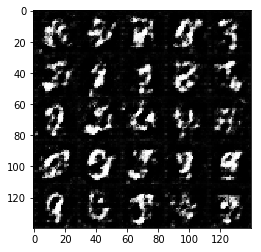

Epoch 1/3... Discriminator Loss: 1.3201... Generator Loss: 0.8242
Epoch 1/3... Discriminator Loss: 1.3076... Generator Loss: 0.8090
Epoch 1/3... Discriminator Loss: 1.2097... Generator Loss: 0.8756
Epoch 1/3... Discriminator Loss: 1.3074... Generator Loss: 0.7320
Epoch 1/3... Discriminator Loss: 1.2661... Generator Loss: 0.7547
Epoch 1/3... Discriminator Loss: 1.2878... Generator Loss: 0.7277
Epoch 1/3... Discriminator Loss: 1.1698... Generator Loss: 0.9452
Epoch 1/3... Discriminator Loss: 1.1823... Generator Loss: 0.9228
Epoch 1/3... Discriminator Loss: 1.2609... Generator Loss: 0.9783
Epoch 1/3... Discriminator Loss: 1.2676... Generator Loss: 0.7598
Epoch 1/3... Discriminator Loss: 1.1903... Generator Loss: 1.0124
Epoch 1/3... Discriminator Loss: 1.2453... Generator Loss: 0.7990
Epoch 1/3... Discriminator Loss: 1.2567... Generator Loss: 1.1764
Epoch 1/3... Discriminator Loss: 1.2333... Generator Loss: 0.9197
Epoch 1/3... Discriminator Loss: 1.1776... Generator Loss: 0.9776
Epoch 1/3.

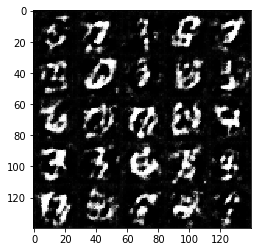

Epoch 1/3... Discriminator Loss: 1.3289... Generator Loss: 0.7298
Epoch 1/3... Discriminator Loss: 1.1101... Generator Loss: 0.8957
Epoch 1/3... Discriminator Loss: 1.1442... Generator Loss: 1.0195
Epoch 1/3... Discriminator Loss: 1.1889... Generator Loss: 1.0632
Epoch 1/3... Discriminator Loss: 1.2669... Generator Loss: 1.0061
Epoch 1/3... Discriminator Loss: 1.2272... Generator Loss: 0.9109
Epoch 1/3... Discriminator Loss: 1.2307... Generator Loss: 0.7594
Epoch 1/3... Discriminator Loss: 1.2083... Generator Loss: 0.8181
Epoch 1/3... Discriminator Loss: 1.1896... Generator Loss: 1.0182
Epoch 1/3... Discriminator Loss: 1.1720... Generator Loss: 1.2383
Epoch 1/3... Discriminator Loss: 1.1948... Generator Loss: 0.9520
Epoch 1/3... Discriminator Loss: 1.1115... Generator Loss: 1.0988
Epoch 1/3... Discriminator Loss: 1.1807... Generator Loss: 0.8920
Epoch 1/3... Discriminator Loss: 1.1639... Generator Loss: 0.9698
Epoch 1/3... Discriminator Loss: 1.2131... Generator Loss: 0.8371
Epoch 1/3.

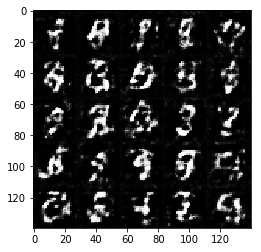

Epoch 1/3... Discriminator Loss: 1.1882... Generator Loss: 0.8828
Epoch 1/3... Discriminator Loss: 1.1286... Generator Loss: 0.9676
Epoch 1/3... Discriminator Loss: 1.1700... Generator Loss: 0.9910
Epoch 1/3... Discriminator Loss: 1.2649... Generator Loss: 0.7454
Epoch 1/3... Discriminator Loss: 1.2024... Generator Loss: 0.8008
Epoch 1/3... Discriminator Loss: 1.1743... Generator Loss: 0.8748
Epoch 1/3... Discriminator Loss: 1.1644... Generator Loss: 1.1911
Epoch 1/3... Discriminator Loss: 1.2225... Generator Loss: 1.2383
Epoch 1/3... Discriminator Loss: 1.1869... Generator Loss: 0.9570
Epoch 1/3... Discriminator Loss: 1.1342... Generator Loss: 1.0373
Epoch 1/3... Discriminator Loss: 1.2002... Generator Loss: 0.8206
Epoch 1/3... Discriminator Loss: 1.1731... Generator Loss: 0.8212
Epoch 1/3... Discriminator Loss: 1.1185... Generator Loss: 1.0883
Epoch 1/3... Discriminator Loss: 1.1714... Generator Loss: 1.0868
Epoch 1/3... Discriminator Loss: 1.0812... Generator Loss: 1.0013
Epoch 1/3.

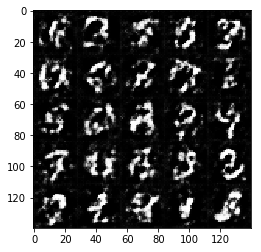

Epoch 1/3... Discriminator Loss: 1.1296... Generator Loss: 1.0497
Epoch 1/3... Discriminator Loss: 1.1602... Generator Loss: 0.9260
Epoch 1/3... Discriminator Loss: 1.0585... Generator Loss: 1.1040
Epoch 1/3... Discriminator Loss: 1.0911... Generator Loss: 1.0577
Epoch 1/3... Discriminator Loss: 1.1109... Generator Loss: 1.0677
Epoch 1/3... Discriminator Loss: 1.1026... Generator Loss: 0.9726
Epoch 1/3... Discriminator Loss: 1.1028... Generator Loss: 0.8835
Epoch 1/3... Discriminator Loss: 1.1402... Generator Loss: 0.8818
Epoch 1/3... Discriminator Loss: 1.0853... Generator Loss: 0.9517
Epoch 1/3... Discriminator Loss: 1.1071... Generator Loss: 1.0022
Epoch 1/3... Discriminator Loss: 1.0770... Generator Loss: 1.1828
Epoch 1/3... Discriminator Loss: 1.1294... Generator Loss: 0.9742
Epoch 1/3... Discriminator Loss: 1.1627... Generator Loss: 0.8631
Epoch 1/3... Discriminator Loss: 1.0991... Generator Loss: 1.1651
Epoch 1/3... Discriminator Loss: 1.1019... Generator Loss: 1.1490
Epoch 1/3.

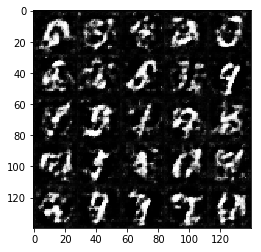

Epoch 1/3... Discriminator Loss: 1.1279... Generator Loss: 1.0353
Epoch 1/3... Discriminator Loss: 1.1724... Generator Loss: 0.7799
Epoch 1/3... Discriminator Loss: 1.1493... Generator Loss: 1.0101
Epoch 1/3... Discriminator Loss: 1.0917... Generator Loss: 0.8688
Epoch 1/3... Discriminator Loss: 1.0900... Generator Loss: 0.9639
Epoch 1/3... Discriminator Loss: 1.1204... Generator Loss: 1.0307
Epoch 1/3... Discriminator Loss: 1.1418... Generator Loss: 0.8828
Epoch 1/3... Discriminator Loss: 1.1603... Generator Loss: 0.9034
Epoch 1/3... Discriminator Loss: 1.0990... Generator Loss: 1.0161
Epoch 1/3... Discriminator Loss: 1.1320... Generator Loss: 1.0592
Epoch 1/3... Discriminator Loss: 1.1133... Generator Loss: 1.1379
Epoch 1/3... Discriminator Loss: 1.1179... Generator Loss: 1.0798
Epoch 1/3... Discriminator Loss: 1.1450... Generator Loss: 1.1443
Epoch 1/3... Discriminator Loss: 1.1038... Generator Loss: 1.4317
Epoch 1/3... Discriminator Loss: 1.1311... Generator Loss: 0.9563
Epoch 1/3.

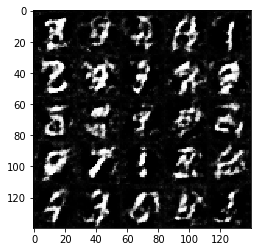

Epoch 1/3... Discriminator Loss: 1.1216... Generator Loss: 0.9797
Epoch 1/3... Discriminator Loss: 1.0496... Generator Loss: 1.2591
Epoch 1/3... Discriminator Loss: 1.1747... Generator Loss: 0.7089
Epoch 1/3... Discriminator Loss: 1.1028... Generator Loss: 1.0079
Epoch 1/3... Discriminator Loss: 1.1474... Generator Loss: 0.9943
Epoch 1/3... Discriminator Loss: 1.0923... Generator Loss: 1.1973
Epoch 1/3... Discriminator Loss: 1.1149... Generator Loss: 1.3261
Epoch 2/3... Discriminator Loss: 1.2256... Generator Loss: 0.8183
Epoch 2/3... Discriminator Loss: 1.2178... Generator Loss: 0.8673
Epoch 2/3... Discriminator Loss: 1.1570... Generator Loss: 1.0371
Epoch 2/3... Discriminator Loss: 1.1241... Generator Loss: 0.9367
Epoch 2/3... Discriminator Loss: 1.1736... Generator Loss: 1.1655
Epoch 2/3... Discriminator Loss: 1.1929... Generator Loss: 0.9998
Epoch 2/3... Discriminator Loss: 1.1087... Generator Loss: 0.9360
Epoch 2/3... Discriminator Loss: 1.1582... Generator Loss: 0.9288
Epoch 2/3.

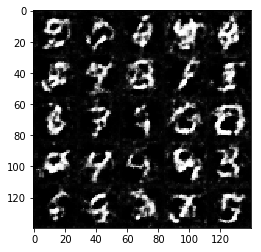

Epoch 2/3... Discriminator Loss: 1.1914... Generator Loss: 0.9020
Epoch 2/3... Discriminator Loss: 1.1254... Generator Loss: 1.1363
Epoch 2/3... Discriminator Loss: 1.1385... Generator Loss: 1.1869
Epoch 2/3... Discriminator Loss: 1.2205... Generator Loss: 0.7627
Epoch 2/3... Discriminator Loss: 1.2037... Generator Loss: 0.8561
Epoch 2/3... Discriminator Loss: 1.2010... Generator Loss: 1.2161
Epoch 2/3... Discriminator Loss: 1.2353... Generator Loss: 1.2242
Epoch 2/3... Discriminator Loss: 1.1838... Generator Loss: 1.0381
Epoch 2/3... Discriminator Loss: 1.1915... Generator Loss: 0.8489
Epoch 2/3... Discriminator Loss: 1.1245... Generator Loss: 1.1257
Epoch 2/3... Discriminator Loss: 1.2767... Generator Loss: 0.9105
Epoch 2/3... Discriminator Loss: 1.2986... Generator Loss: 0.6441
Epoch 2/3... Discriminator Loss: 1.1392... Generator Loss: 1.1808
Epoch 2/3... Discriminator Loss: 1.1726... Generator Loss: 0.9280
Epoch 2/3... Discriminator Loss: 1.2249... Generator Loss: 1.0146
Epoch 2/3.

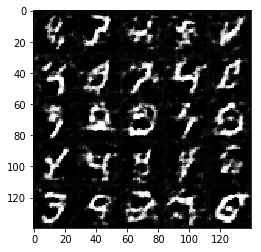

Epoch 2/3... Discriminator Loss: 1.1528... Generator Loss: 1.0875
Epoch 2/3... Discriminator Loss: 1.2280... Generator Loss: 0.9008
Epoch 2/3... Discriminator Loss: 1.1924... Generator Loss: 1.0304
Epoch 2/3... Discriminator Loss: 1.2649... Generator Loss: 1.1249
Epoch 2/3... Discriminator Loss: 1.3366... Generator Loss: 1.1944
Epoch 2/3... Discriminator Loss: 1.1714... Generator Loss: 0.9384
Epoch 2/3... Discriminator Loss: 1.2039... Generator Loss: 0.7717
Epoch 2/3... Discriminator Loss: 1.2348... Generator Loss: 0.9690
Epoch 2/3... Discriminator Loss: 1.1968... Generator Loss: 0.8542
Epoch 2/3... Discriminator Loss: 1.2245... Generator Loss: 0.7538
Epoch 2/3... Discriminator Loss: 1.2259... Generator Loss: 0.8124
Epoch 2/3... Discriminator Loss: 1.2074... Generator Loss: 0.9580
Epoch 2/3... Discriminator Loss: 1.2134... Generator Loss: 0.7308
Epoch 2/3... Discriminator Loss: 1.2593... Generator Loss: 0.8028
Epoch 2/3... Discriminator Loss: 1.2436... Generator Loss: 0.9706
Epoch 2/3.

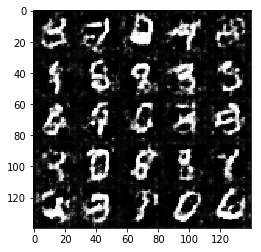

Epoch 2/3... Discriminator Loss: 1.2024... Generator Loss: 1.0455
Epoch 2/3... Discriminator Loss: 1.3003... Generator Loss: 0.7228
Epoch 2/3... Discriminator Loss: 1.1632... Generator Loss: 1.0655
Epoch 2/3... Discriminator Loss: 1.1664... Generator Loss: 1.0061
Epoch 2/3... Discriminator Loss: 1.2654... Generator Loss: 1.0001
Epoch 2/3... Discriminator Loss: 1.1798... Generator Loss: 0.8945
Epoch 2/3... Discriminator Loss: 1.1896... Generator Loss: 0.8807
Epoch 2/3... Discriminator Loss: 1.2930... Generator Loss: 0.7572
Epoch 2/3... Discriminator Loss: 1.2277... Generator Loss: 0.8652
Epoch 2/3... Discriminator Loss: 1.2026... Generator Loss: 0.8954
Epoch 2/3... Discriminator Loss: 1.2651... Generator Loss: 0.9818
Epoch 2/3... Discriminator Loss: 1.2064... Generator Loss: 0.8861
Epoch 2/3... Discriminator Loss: 1.2846... Generator Loss: 0.7334
Epoch 2/3... Discriminator Loss: 1.2154... Generator Loss: 1.0637
Epoch 2/3... Discriminator Loss: 1.2806... Generator Loss: 1.2322
Epoch 2/3.

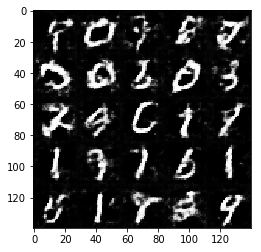

Epoch 2/3... Discriminator Loss: 1.2739... Generator Loss: 0.8886
Epoch 2/3... Discriminator Loss: 1.1914... Generator Loss: 1.1181
Epoch 2/3... Discriminator Loss: 1.1790... Generator Loss: 1.0083
Epoch 2/3... Discriminator Loss: 1.2220... Generator Loss: 0.7953
Epoch 2/3... Discriminator Loss: 1.2252... Generator Loss: 0.9381
Epoch 2/3... Discriminator Loss: 1.1933... Generator Loss: 0.8144
Epoch 2/3... Discriminator Loss: 1.1929... Generator Loss: 0.9746
Epoch 2/3... Discriminator Loss: 1.2710... Generator Loss: 0.9040
Epoch 2/3... Discriminator Loss: 1.2248... Generator Loss: 0.8240
Epoch 2/3... Discriminator Loss: 1.2610... Generator Loss: 1.0693
Epoch 2/3... Discriminator Loss: 1.1956... Generator Loss: 1.0014
Epoch 2/3... Discriminator Loss: 1.1994... Generator Loss: 0.7955
Epoch 2/3... Discriminator Loss: 1.2071... Generator Loss: 0.9177
Epoch 2/3... Discriminator Loss: 1.2634... Generator Loss: 0.8345
Epoch 2/3... Discriminator Loss: 1.2829... Generator Loss: 1.1435
Epoch 2/3.

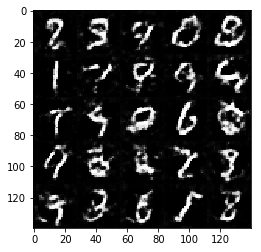

Epoch 2/3... Discriminator Loss: 1.1947... Generator Loss: 0.9527
Epoch 2/3... Discriminator Loss: 1.2479... Generator Loss: 0.6781
Epoch 2/3... Discriminator Loss: 1.2209... Generator Loss: 0.8871
Epoch 2/3... Discriminator Loss: 1.2938... Generator Loss: 0.7846
Epoch 2/3... Discriminator Loss: 1.2832... Generator Loss: 0.7515
Epoch 2/3... Discriminator Loss: 1.2042... Generator Loss: 0.9934
Epoch 2/3... Discriminator Loss: 1.1904... Generator Loss: 0.7760
Epoch 2/3... Discriminator Loss: 1.2818... Generator Loss: 0.8253
Epoch 2/3... Discriminator Loss: 1.2838... Generator Loss: 0.7969
Epoch 2/3... Discriminator Loss: 1.3161... Generator Loss: 0.7999
Epoch 2/3... Discriminator Loss: 1.2894... Generator Loss: 1.1115
Epoch 2/3... Discriminator Loss: 1.2741... Generator Loss: 0.7404
Epoch 2/3... Discriminator Loss: 1.2664... Generator Loss: 0.9487
Epoch 2/3... Discriminator Loss: 1.2235... Generator Loss: 0.8935
Epoch 2/3... Discriminator Loss: 1.2540... Generator Loss: 1.0235
Epoch 2/3.

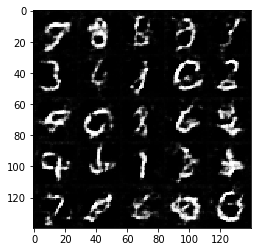

Epoch 2/3... Discriminator Loss: 1.2601... Generator Loss: 1.0145
Epoch 2/3... Discriminator Loss: 1.2466... Generator Loss: 0.9030
Epoch 2/3... Discriminator Loss: 1.2970... Generator Loss: 0.7200
Epoch 2/3... Discriminator Loss: 1.2343... Generator Loss: 0.8502
Epoch 2/3... Discriminator Loss: 1.1262... Generator Loss: 0.9046
Epoch 2/3... Discriminator Loss: 1.2840... Generator Loss: 0.8539
Epoch 2/3... Discriminator Loss: 1.3147... Generator Loss: 0.6208
Epoch 2/3... Discriminator Loss: 1.2774... Generator Loss: 0.8564
Epoch 2/3... Discriminator Loss: 1.4004... Generator Loss: 0.6875
Epoch 2/3... Discriminator Loss: 1.2332... Generator Loss: 0.8103
Epoch 2/3... Discriminator Loss: 1.2154... Generator Loss: 0.7851
Epoch 2/3... Discriminator Loss: 1.2782... Generator Loss: 0.8682
Epoch 2/3... Discriminator Loss: 1.2557... Generator Loss: 0.9095
Epoch 2/3... Discriminator Loss: 1.1859... Generator Loss: 0.9330
Epoch 2/3... Discriminator Loss: 1.2178... Generator Loss: 0.9365
Epoch 2/3.

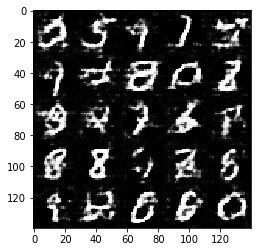

Epoch 2/3... Discriminator Loss: 1.2790... Generator Loss: 0.8861
Epoch 2/3... Discriminator Loss: 1.2434... Generator Loss: 0.7345
Epoch 2/3... Discriminator Loss: 1.3013... Generator Loss: 0.7114
Epoch 2/3... Discriminator Loss: 1.1922... Generator Loss: 0.8418
Epoch 2/3... Discriminator Loss: 1.2502... Generator Loss: 0.7641
Epoch 2/3... Discriminator Loss: 1.2736... Generator Loss: 0.7986
Epoch 2/3... Discriminator Loss: 1.2136... Generator Loss: 0.8354
Epoch 2/3... Discriminator Loss: 1.2363... Generator Loss: 0.9359
Epoch 2/3... Discriminator Loss: 1.2363... Generator Loss: 1.0291
Epoch 2/3... Discriminator Loss: 1.2853... Generator Loss: 0.8986
Epoch 2/3... Discriminator Loss: 1.2107... Generator Loss: 0.8855
Epoch 2/3... Discriminator Loss: 1.2765... Generator Loss: 0.7110
Epoch 2/3... Discriminator Loss: 1.3565... Generator Loss: 0.6575
Epoch 2/3... Discriminator Loss: 1.1630... Generator Loss: 1.0322
Epoch 2/3... Discriminator Loss: 1.3149... Generator Loss: 0.8319
Epoch 2/3.

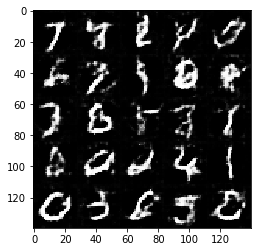

Epoch 2/3... Discriminator Loss: 1.2285... Generator Loss: 1.2668
Epoch 2/3... Discriminator Loss: 1.3011... Generator Loss: 0.8679
Epoch 2/3... Discriminator Loss: 1.2247... Generator Loss: 0.9444
Epoch 2/3... Discriminator Loss: 1.2811... Generator Loss: 0.7180
Epoch 2/3... Discriminator Loss: 1.3257... Generator Loss: 0.8355
Epoch 2/3... Discriminator Loss: 1.2406... Generator Loss: 0.8963
Epoch 2/3... Discriminator Loss: 1.1163... Generator Loss: 1.0337
Epoch 2/3... Discriminator Loss: 1.1914... Generator Loss: 0.9914
Epoch 2/3... Discriminator Loss: 1.2748... Generator Loss: 0.7864
Epoch 2/3... Discriminator Loss: 1.2291... Generator Loss: 0.9303
Epoch 2/3... Discriminator Loss: 1.2745... Generator Loss: 0.8706
Epoch 2/3... Discriminator Loss: 1.2412... Generator Loss: 0.7979
Epoch 2/3... Discriminator Loss: 1.2283... Generator Loss: 0.8148
Epoch 2/3... Discriminator Loss: 1.2372... Generator Loss: 1.0549
Epoch 2/3... Discriminator Loss: 1.1441... Generator Loss: 0.8138
Epoch 2/3.

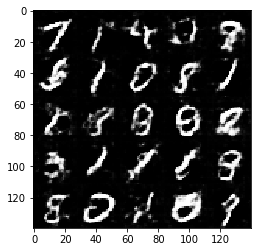

Epoch 2/3... Discriminator Loss: 1.2522... Generator Loss: 0.8790
Epoch 2/3... Discriminator Loss: 1.2876... Generator Loss: 0.7420
Epoch 2/3... Discriminator Loss: 1.1747... Generator Loss: 1.0554
Epoch 2/3... Discriminator Loss: 1.2361... Generator Loss: 0.8214
Epoch 2/3... Discriminator Loss: 1.3053... Generator Loss: 0.9649
Epoch 2/3... Discriminator Loss: 1.2623... Generator Loss: 0.9050
Epoch 2/3... Discriminator Loss: 1.3363... Generator Loss: 0.9190
Epoch 2/3... Discriminator Loss: 1.2820... Generator Loss: 0.7899
Epoch 2/3... Discriminator Loss: 1.2786... Generator Loss: 0.7791
Epoch 2/3... Discriminator Loss: 1.3260... Generator Loss: 0.6819
Epoch 2/3... Discriminator Loss: 1.2246... Generator Loss: 0.9704
Epoch 2/3... Discriminator Loss: 1.3195... Generator Loss: 1.0083
Epoch 2/3... Discriminator Loss: 1.2722... Generator Loss: 0.7989
Epoch 2/3... Discriminator Loss: 1.2645... Generator Loss: 0.7376
Epoch 3/3... Discriminator Loss: 1.3065... Generator Loss: 0.7774
Epoch 3/3.

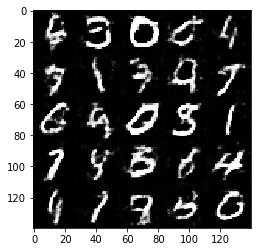

Epoch 3/3... Discriminator Loss: 1.1999... Generator Loss: 0.8544
Epoch 3/3... Discriminator Loss: 1.2187... Generator Loss: 0.9190
Epoch 3/3... Discriminator Loss: 1.1713... Generator Loss: 0.9152
Epoch 3/3... Discriminator Loss: 1.2249... Generator Loss: 0.8832
Epoch 3/3... Discriminator Loss: 1.2295... Generator Loss: 0.8908
Epoch 3/3... Discriminator Loss: 1.2174... Generator Loss: 1.0017
Epoch 3/3... Discriminator Loss: 1.2667... Generator Loss: 0.7556
Epoch 3/3... Discriminator Loss: 1.3109... Generator Loss: 0.9022
Epoch 3/3... Discriminator Loss: 1.1902... Generator Loss: 0.9416
Epoch 3/3... Discriminator Loss: 1.3084... Generator Loss: 1.0416
Epoch 3/3... Discriminator Loss: 1.2812... Generator Loss: 0.9590
Epoch 3/3... Discriminator Loss: 1.3464... Generator Loss: 0.7009
Epoch 3/3... Discriminator Loss: 1.2605... Generator Loss: 0.8221
Epoch 3/3... Discriminator Loss: 1.1818... Generator Loss: 0.9279
Epoch 3/3... Discriminator Loss: 1.2711... Generator Loss: 0.8310
Epoch 3/3.

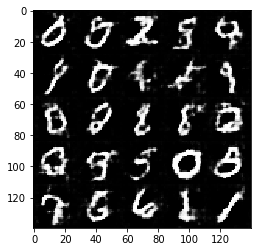

Epoch 3/3... Discriminator Loss: 1.1868... Generator Loss: 0.9119
Epoch 3/3... Discriminator Loss: 1.3736... Generator Loss: 0.6736
Epoch 3/3... Discriminator Loss: 1.1956... Generator Loss: 0.8047
Epoch 3/3... Discriminator Loss: 1.1827... Generator Loss: 0.8807
Epoch 3/3... Discriminator Loss: 1.2914... Generator Loss: 0.6917
Epoch 3/3... Discriminator Loss: 1.2579... Generator Loss: 0.7304
Epoch 3/3... Discriminator Loss: 1.2430... Generator Loss: 0.8958
Epoch 3/3... Discriminator Loss: 1.2456... Generator Loss: 0.9122
Epoch 3/3... Discriminator Loss: 1.2131... Generator Loss: 0.8904
Epoch 3/3... Discriminator Loss: 1.2998... Generator Loss: 0.7518
Epoch 3/3... Discriminator Loss: 1.2780... Generator Loss: 0.7472
Epoch 3/3... Discriminator Loss: 1.2086... Generator Loss: 0.8898
Epoch 3/3... Discriminator Loss: 1.1415... Generator Loss: 0.9145
Epoch 3/3... Discriminator Loss: 1.3469... Generator Loss: 0.6889
Epoch 3/3... Discriminator Loss: 1.2313... Generator Loss: 0.8482
Epoch 3/3.

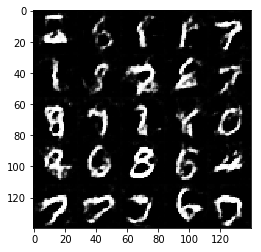

Epoch 3/3... Discriminator Loss: 1.2635... Generator Loss: 0.7770
Epoch 3/3... Discriminator Loss: 1.2390... Generator Loss: 0.8836
Epoch 3/3... Discriminator Loss: 1.2675... Generator Loss: 0.8121
Epoch 3/3... Discriminator Loss: 1.3371... Generator Loss: 0.6452
Epoch 3/3... Discriminator Loss: 1.2626... Generator Loss: 0.9485
Epoch 3/3... Discriminator Loss: 1.3211... Generator Loss: 0.8095
Epoch 3/3... Discriminator Loss: 1.2332... Generator Loss: 0.8593
Epoch 3/3... Discriminator Loss: 1.2609... Generator Loss: 0.7533
Epoch 3/3... Discriminator Loss: 1.2752... Generator Loss: 0.9608
Epoch 3/3... Discriminator Loss: 1.2738... Generator Loss: 0.7365
Epoch 3/3... Discriminator Loss: 1.2369... Generator Loss: 0.9711
Epoch 3/3... Discriminator Loss: 1.2272... Generator Loss: 0.9958
Epoch 3/3... Discriminator Loss: 1.3156... Generator Loss: 0.6979
Epoch 3/3... Discriminator Loss: 1.2632... Generator Loss: 0.8120
Epoch 3/3... Discriminator Loss: 1.2488... Generator Loss: 0.8918
Epoch 3/3.

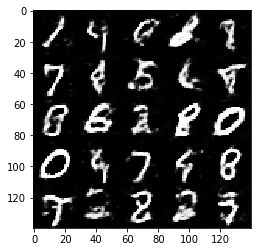

Epoch 3/3... Discriminator Loss: 1.2839... Generator Loss: 0.9070
Epoch 3/3... Discriminator Loss: 1.2502... Generator Loss: 0.8958
Epoch 3/3... Discriminator Loss: 1.2129... Generator Loss: 0.8700
Epoch 3/3... Discriminator Loss: 1.2805... Generator Loss: 0.8617
Epoch 3/3... Discriminator Loss: 1.1944... Generator Loss: 0.9960
Epoch 3/3... Discriminator Loss: 1.2985... Generator Loss: 0.8349
Epoch 3/3... Discriminator Loss: 1.3480... Generator Loss: 0.7766
Epoch 3/3... Discriminator Loss: 1.3184... Generator Loss: 0.7209
Epoch 3/3... Discriminator Loss: 1.1345... Generator Loss: 0.9332
Epoch 3/3... Discriminator Loss: 1.2855... Generator Loss: 0.7700
Epoch 3/3... Discriminator Loss: 1.3032... Generator Loss: 0.8745
Epoch 3/3... Discriminator Loss: 1.2337... Generator Loss: 0.9521
Epoch 3/3... Discriminator Loss: 1.2624... Generator Loss: 0.7709
Epoch 3/3... Discriminator Loss: 1.2521... Generator Loss: 0.8853
Epoch 3/3... Discriminator Loss: 1.3077... Generator Loss: 0.7846
Epoch 3/3.

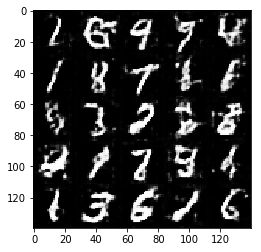

Epoch 3/3... Discriminator Loss: 1.3266... Generator Loss: 0.7025
Epoch 3/3... Discriminator Loss: 1.1588... Generator Loss: 1.0012
Epoch 3/3... Discriminator Loss: 1.2403... Generator Loss: 0.8994
Epoch 3/3... Discriminator Loss: 1.3008... Generator Loss: 0.8154
Epoch 3/3... Discriminator Loss: 1.2305... Generator Loss: 0.8450
Epoch 3/3... Discriminator Loss: 1.2282... Generator Loss: 0.7914
Epoch 3/3... Discriminator Loss: 1.2927... Generator Loss: 0.7424
Epoch 3/3... Discriminator Loss: 1.2507... Generator Loss: 0.8502
Epoch 3/3... Discriminator Loss: 1.2580... Generator Loss: 0.8811
Epoch 3/3... Discriminator Loss: 1.2779... Generator Loss: 0.8290
Epoch 3/3... Discriminator Loss: 1.2631... Generator Loss: 0.8643
Epoch 3/3... Discriminator Loss: 1.2422... Generator Loss: 0.7681
Epoch 3/3... Discriminator Loss: 1.2573... Generator Loss: 1.0670
Epoch 3/3... Discriminator Loss: 1.2825... Generator Loss: 0.8383
Epoch 3/3... Discriminator Loss: 1.2461... Generator Loss: 0.8144
Epoch 3/3.

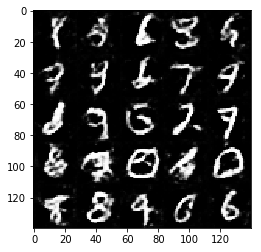

Epoch 3/3... Discriminator Loss: 1.2825... Generator Loss: 0.9898
Epoch 3/3... Discriminator Loss: 1.2946... Generator Loss: 1.0119
Epoch 3/3... Discriminator Loss: 1.2706... Generator Loss: 0.8666
Epoch 3/3... Discriminator Loss: 1.2734... Generator Loss: 0.7027
Epoch 3/3... Discriminator Loss: 1.2433... Generator Loss: 0.8798
Epoch 3/3... Discriminator Loss: 1.2366... Generator Loss: 0.8322
Epoch 3/3... Discriminator Loss: 1.3030... Generator Loss: 0.7571
Epoch 3/3... Discriminator Loss: 1.3184... Generator Loss: 0.8169
Epoch 3/3... Discriminator Loss: 1.2751... Generator Loss: 0.8909
Epoch 3/3... Discriminator Loss: 1.2308... Generator Loss: 0.9937
Epoch 3/3... Discriminator Loss: 1.2613... Generator Loss: 0.8787
Epoch 3/3... Discriminator Loss: 1.3157... Generator Loss: 0.7224
Epoch 3/3... Discriminator Loss: 1.2586... Generator Loss: 0.7637
Epoch 3/3... Discriminator Loss: 1.2994... Generator Loss: 0.8525
Epoch 3/3... Discriminator Loss: 1.2410... Generator Loss: 1.0235
Epoch 3/3.

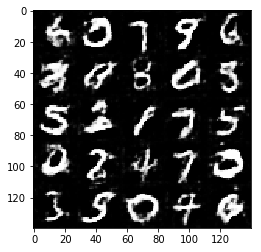

Epoch 3/3... Discriminator Loss: 1.2856... Generator Loss: 0.7745
Epoch 3/3... Discriminator Loss: 1.3159... Generator Loss: 0.6943
Epoch 3/3... Discriminator Loss: 1.2356... Generator Loss: 0.9249
Epoch 3/3... Discriminator Loss: 1.2632... Generator Loss: 0.8923
Epoch 3/3... Discriminator Loss: 1.2750... Generator Loss: 0.7887
Epoch 3/3... Discriminator Loss: 1.2728... Generator Loss: 0.8489
Epoch 3/3... Discriminator Loss: 1.2442... Generator Loss: 0.8719
Epoch 3/3... Discriminator Loss: 1.1930... Generator Loss: 0.8303
Epoch 3/3... Discriminator Loss: 1.3186... Generator Loss: 0.6997
Epoch 3/3... Discriminator Loss: 1.2208... Generator Loss: 0.8917
Epoch 3/3... Discriminator Loss: 1.2791... Generator Loss: 0.7832
Epoch 3/3... Discriminator Loss: 1.2852... Generator Loss: 0.8037
Epoch 3/3... Discriminator Loss: 1.2855... Generator Loss: 0.8791
Epoch 3/3... Discriminator Loss: 1.2148... Generator Loss: 0.9715
Epoch 3/3... Discriminator Loss: 1.2560... Generator Loss: 0.9570
Epoch 3/3.

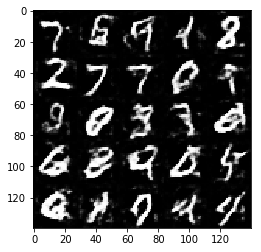

Epoch 3/3... Discriminator Loss: 1.3006... Generator Loss: 0.8275
Epoch 3/3... Discriminator Loss: 1.2908... Generator Loss: 0.8203
Epoch 3/3... Discriminator Loss: 1.2208... Generator Loss: 0.8813
Epoch 3/3... Discriminator Loss: 1.3608... Generator Loss: 0.8150
Epoch 3/3... Discriminator Loss: 1.2771... Generator Loss: 0.9256
Epoch 3/3... Discriminator Loss: 1.2904... Generator Loss: 1.1341
Epoch 3/3... Discriminator Loss: 1.3119... Generator Loss: 0.8080
Epoch 3/3... Discriminator Loss: 1.2388... Generator Loss: 0.9520
Epoch 3/3... Discriminator Loss: 1.2980... Generator Loss: 0.9448
Epoch 3/3... Discriminator Loss: 1.2738... Generator Loss: 0.8746
Epoch 3/3... Discriminator Loss: 1.2579... Generator Loss: 0.7889
Epoch 3/3... Discriminator Loss: 1.2410... Generator Loss: 0.7864
Epoch 3/3... Discriminator Loss: 1.3808... Generator Loss: 0.9936
Epoch 3/3... Discriminator Loss: 1.3434... Generator Loss: 0.9155
Epoch 3/3... Discriminator Loss: 1.2303... Generator Loss: 0.9798
Epoch 3/3.

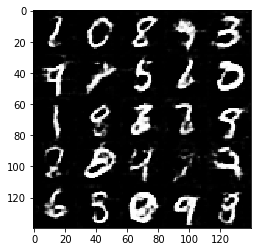

Epoch 3/3... Discriminator Loss: 1.2671... Generator Loss: 0.9943
Epoch 3/3... Discriminator Loss: 1.2680... Generator Loss: 0.8626
Epoch 3/3... Discriminator Loss: 1.2705... Generator Loss: 0.8348
Epoch 3/3... Discriminator Loss: 1.3033... Generator Loss: 0.7004
Epoch 3/3... Discriminator Loss: 1.2564... Generator Loss: 0.8749
Epoch 3/3... Discriminator Loss: 1.2546... Generator Loss: 0.7832
Epoch 3/3... Discriminator Loss: 1.3083... Generator Loss: 0.7381
Epoch 3/3... Discriminator Loss: 1.1842... Generator Loss: 0.9398
Epoch 3/3... Discriminator Loss: 1.2981... Generator Loss: 0.7878
Epoch 3/3... Discriminator Loss: 1.2264... Generator Loss: 1.0058
Epoch 3/3... Discriminator Loss: 1.3359... Generator Loss: 0.7898
Epoch 3/3... Discriminator Loss: 1.2821... Generator Loss: 0.8534
Epoch 3/3... Discriminator Loss: 1.2764... Generator Loss: 0.8870
Epoch 3/3... Discriminator Loss: 1.2852... Generator Loss: 0.8557
Epoch 3/3... Discriminator Loss: 1.2894... Generator Loss: 1.0325
Epoch 3/3.

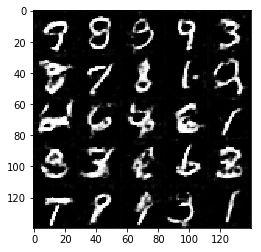

Epoch 3/3... Discriminator Loss: 1.2416... Generator Loss: 0.7570
Epoch 3/3... Discriminator Loss: 1.2878... Generator Loss: 0.7525


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Shape: (202599, 28, 28, 3)
Learning rate: 0.0002
Tensor("input_real:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("input_z:0", shape=(?, 128), dtype=float32)
Epoch 1/6... Discriminator Loss: 1.1003... Generator Loss: 0.7900
Epoch 1/6... Discriminator Loss: 0.9388... Generator Loss: 1.0178
Epoch 1/6... Discriminator Loss: 1.0697... Generator Loss: 0.8986
Epoch 1/6... Discriminator Loss: 0.4054... Generator Loss: 4.0422
Epoch 1/6... Discriminator Loss: 2.2092... Generator Loss: 0.2261
Epoch 1/6... Discriminator Loss: 0.4554... Generator Loss: 9.2646
Epoch 1/6... Discriminator Loss: 0.5326... Generator Loss: 2.9882
Epoch 1/6... Discriminator Loss: 8.3735... Generator Loss: 0.0004
Epoch 1/6... Discriminator Loss: 2.6870... Generator Loss: 0.1292
Epoch 1/6... Discriminator Loss: 0.4101... Generator Loss: 3.5363
Epoch 1/6... Discriminator Loss: 0.4695... Generator Loss: 2.6124
Epoch 1/6... Discriminator Loss: 0.7698... Generator Loss: 1.2171
Epoch 1/6... Discriminator Loss: 0.5244... Gener

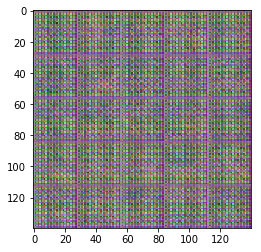

Epoch 1/6... Discriminator Loss: 0.6228... Generator Loss: 1.6564
Epoch 1/6... Discriminator Loss: 0.6488... Generator Loss: 1.6577
Epoch 1/6... Discriminator Loss: 0.6279... Generator Loss: 1.7084
Epoch 1/6... Discriminator Loss: 0.6578... Generator Loss: 1.6229
Epoch 1/6... Discriminator Loss: 0.7206... Generator Loss: 1.4052
Epoch 1/6... Discriminator Loss: 0.7952... Generator Loss: 1.2978
Epoch 1/6... Discriminator Loss: 0.7901... Generator Loss: 1.5375
Epoch 1/6... Discriminator Loss: 1.5078... Generator Loss: 0.9089
Epoch 1/6... Discriminator Loss: 1.0937... Generator Loss: 1.1602
Epoch 1/6... Discriminator Loss: 1.3590... Generator Loss: 1.9311
Epoch 1/6... Discriminator Loss: 1.5709... Generator Loss: 0.5012
Epoch 1/6... Discriminator Loss: 1.3398... Generator Loss: 1.3913
Epoch 1/6... Discriminator Loss: 1.4425... Generator Loss: 0.5507
Epoch 1/6... Discriminator Loss: 1.5579... Generator Loss: 1.7484
Epoch 1/6... Discriminator Loss: 1.1943... Generator Loss: 0.9195
Epoch 1/6.

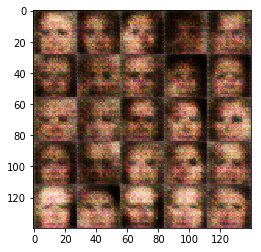

Epoch 1/6... Discriminator Loss: 1.2402... Generator Loss: 0.8628
Epoch 1/6... Discriminator Loss: 1.4672... Generator Loss: 1.7479
Epoch 1/6... Discriminator Loss: 1.2976... Generator Loss: 0.7367
Epoch 1/6... Discriminator Loss: 1.4915... Generator Loss: 1.4929
Epoch 1/6... Discriminator Loss: 1.2463... Generator Loss: 0.8187
Epoch 1/6... Discriminator Loss: 1.2329... Generator Loss: 0.9029
Epoch 1/6... Discriminator Loss: 1.0811... Generator Loss: 1.1491
Epoch 1/6... Discriminator Loss: 1.1230... Generator Loss: 0.9647
Epoch 1/6... Discriminator Loss: 0.9726... Generator Loss: 1.4035
Epoch 1/6... Discriminator Loss: 1.4019... Generator Loss: 0.5640
Epoch 1/6... Discriminator Loss: 1.2713... Generator Loss: 1.1736
Epoch 1/6... Discriminator Loss: 1.3079... Generator Loss: 0.9922
Epoch 1/6... Discriminator Loss: 1.4705... Generator Loss: 0.4936
Epoch 1/6... Discriminator Loss: 1.3726... Generator Loss: 1.3309
Epoch 1/6... Discriminator Loss: 1.3294... Generator Loss: 0.8126
Epoch 1/6.

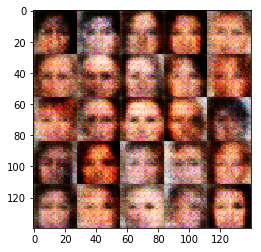

Epoch 1/6... Discriminator Loss: 1.5603... Generator Loss: 0.5449
Epoch 1/6... Discriminator Loss: 1.3245... Generator Loss: 0.9294
Epoch 1/6... Discriminator Loss: 1.5615... Generator Loss: 0.4418
Epoch 1/6... Discriminator Loss: 1.4266... Generator Loss: 0.7775
Epoch 1/6... Discriminator Loss: 1.2559... Generator Loss: 0.8599
Epoch 1/6... Discriminator Loss: 1.4377... Generator Loss: 0.8386
Epoch 1/6... Discriminator Loss: 1.4460... Generator Loss: 0.8100
Epoch 1/6... Discriminator Loss: 1.4478... Generator Loss: 0.6229
Epoch 1/6... Discriminator Loss: 1.7227... Generator Loss: 1.3015
Epoch 1/6... Discriminator Loss: 1.3315... Generator Loss: 1.2494
Epoch 1/6... Discriminator Loss: 1.5011... Generator Loss: 0.5450
Epoch 1/6... Discriminator Loss: 1.4940... Generator Loss: 1.2344
Epoch 1/6... Discriminator Loss: 1.4517... Generator Loss: 0.6968
Epoch 1/6... Discriminator Loss: 1.4099... Generator Loss: 0.5734
Epoch 1/6... Discriminator Loss: 1.4349... Generator Loss: 0.8062
Epoch 1/6.

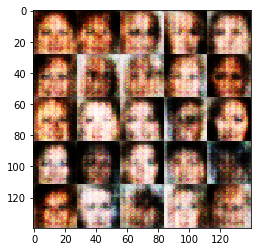

Epoch 1/6... Discriminator Loss: 1.3159... Generator Loss: 0.6398
Epoch 1/6... Discriminator Loss: 1.4042... Generator Loss: 0.7607
Epoch 1/6... Discriminator Loss: 1.4752... Generator Loss: 0.6699
Epoch 1/6... Discriminator Loss: 1.6546... Generator Loss: 0.8809
Epoch 1/6... Discriminator Loss: 1.3286... Generator Loss: 0.6392
Epoch 1/6... Discriminator Loss: 1.4147... Generator Loss: 0.7813
Epoch 1/6... Discriminator Loss: 1.4610... Generator Loss: 0.6789
Epoch 1/6... Discriminator Loss: 1.3097... Generator Loss: 1.0637
Epoch 1/6... Discriminator Loss: 1.5795... Generator Loss: 0.4498
Epoch 1/6... Discriminator Loss: 1.2107... Generator Loss: 0.9410
Epoch 1/6... Discriminator Loss: 1.3599... Generator Loss: 0.8327
Epoch 1/6... Discriminator Loss: 1.4190... Generator Loss: 0.5925
Epoch 1/6... Discriminator Loss: 1.3150... Generator Loss: 0.9903
Epoch 1/6... Discriminator Loss: 1.3896... Generator Loss: 0.7476
Epoch 1/6... Discriminator Loss: 1.5454... Generator Loss: 0.4985
Epoch 1/6.

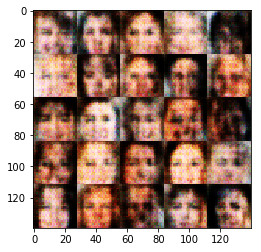

Epoch 1/6... Discriminator Loss: 1.3359... Generator Loss: 0.8126
Epoch 1/6... Discriminator Loss: 1.4373... Generator Loss: 0.6911
Epoch 1/6... Discriminator Loss: 1.5393... Generator Loss: 0.7821
Epoch 1/6... Discriminator Loss: 1.4081... Generator Loss: 0.9506
Epoch 1/6... Discriminator Loss: 1.4257... Generator Loss: 0.8916
Epoch 1/6... Discriminator Loss: 1.3607... Generator Loss: 0.7146
Epoch 1/6... Discriminator Loss: 1.3094... Generator Loss: 1.0637
Epoch 1/6... Discriminator Loss: 1.4814... Generator Loss: 0.6392
Epoch 1/6... Discriminator Loss: 1.2151... Generator Loss: 1.0622
Epoch 1/6... Discriminator Loss: 1.5624... Generator Loss: 0.5444
Epoch 1/6... Discriminator Loss: 1.4897... Generator Loss: 0.6766
Epoch 1/6... Discriminator Loss: 1.3237... Generator Loss: 0.9787
Epoch 1/6... Discriminator Loss: 1.2419... Generator Loss: 0.8292
Epoch 1/6... Discriminator Loss: 1.3748... Generator Loss: 0.8248
Epoch 1/6... Discriminator Loss: 1.3481... Generator Loss: 0.8042
Epoch 1/6.

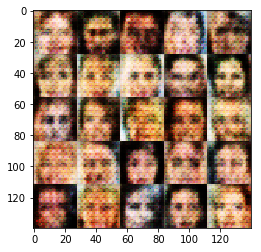

Epoch 1/6... Discriminator Loss: 1.3686... Generator Loss: 0.7302
Epoch 1/6... Discriminator Loss: 1.3760... Generator Loss: 0.7518
Epoch 1/6... Discriminator Loss: 1.3532... Generator Loss: 0.7769
Epoch 1/6... Discriminator Loss: 1.2486... Generator Loss: 0.8263
Epoch 1/6... Discriminator Loss: 1.0528... Generator Loss: 0.8035
Epoch 1/6... Discriminator Loss: 0.7016... Generator Loss: 1.6012
Epoch 1/6... Discriminator Loss: 1.3276... Generator Loss: 0.5586
Epoch 1/6... Discriminator Loss: 1.7418... Generator Loss: 2.0584
Epoch 1/6... Discriminator Loss: 0.6314... Generator Loss: 2.7759
Epoch 1/6... Discriminator Loss: 0.9195... Generator Loss: 0.9776
Epoch 1/6... Discriminator Loss: 0.4072... Generator Loss: 3.2936
Epoch 1/6... Discriminator Loss: 0.4974... Generator Loss: 4.2853
Epoch 1/6... Discriminator Loss: 0.7077... Generator Loss: 1.3768
Epoch 1/6... Discriminator Loss: 0.4488... Generator Loss: 4.6728
Epoch 1/6... Discriminator Loss: 0.5220... Generator Loss: 2.3253
Epoch 1/6.

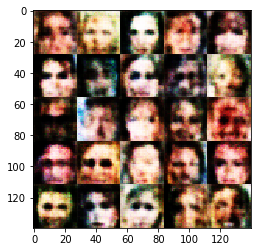

Epoch 1/6... Discriminator Loss: 0.9224... Generator Loss: 0.9420
Epoch 1/6... Discriminator Loss: 0.9703... Generator Loss: 2.2632
Epoch 1/6... Discriminator Loss: 0.4086... Generator Loss: 3.7993
Epoch 1/6... Discriminator Loss: 0.7560... Generator Loss: 3.1472
Epoch 1/6... Discriminator Loss: 0.8233... Generator Loss: 1.0915
Epoch 1/6... Discriminator Loss: 0.4639... Generator Loss: 2.5997
Epoch 1/6... Discriminator Loss: 0.5200... Generator Loss: 2.0955
Epoch 1/6... Discriminator Loss: 1.1042... Generator Loss: 6.4659
Epoch 1/6... Discriminator Loss: 0.6887... Generator Loss: 1.6045
Epoch 1/6... Discriminator Loss: 1.3585... Generator Loss: 0.5068
Epoch 1/6... Discriminator Loss: 0.6027... Generator Loss: 1.5869
Epoch 1/6... Discriminator Loss: 0.8393... Generator Loss: 1.0458
Epoch 1/6... Discriminator Loss: 0.7268... Generator Loss: 1.5335
Epoch 1/6... Discriminator Loss: 1.0383... Generator Loss: 0.7718
Epoch 1/6... Discriminator Loss: 0.6026... Generator Loss: 1.6947
Epoch 1/6.

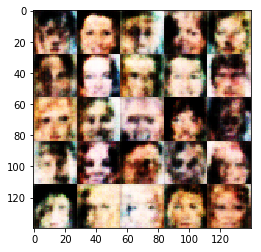

Epoch 1/6... Discriminator Loss: 0.5226... Generator Loss: 2.2837
Epoch 1/6... Discriminator Loss: 0.5525... Generator Loss: 2.1974
Epoch 1/6... Discriminator Loss: 0.4791... Generator Loss: 2.3664
Epoch 1/6... Discriminator Loss: 1.0777... Generator Loss: 0.7373
Epoch 1/6... Discriminator Loss: 0.5721... Generator Loss: 1.8731
Epoch 1/6... Discriminator Loss: 0.5973... Generator Loss: 2.8284
Epoch 1/6... Discriminator Loss: 1.0219... Generator Loss: 0.8370
Epoch 1/6... Discriminator Loss: 1.1135... Generator Loss: 0.8488
Epoch 1/6... Discriminator Loss: 0.6244... Generator Loss: 1.7005
Epoch 1/6... Discriminator Loss: 0.4794... Generator Loss: 2.6463
Epoch 1/6... Discriminator Loss: 0.4835... Generator Loss: 2.8017
Epoch 1/6... Discriminator Loss: 1.1483... Generator Loss: 0.6650
Epoch 1/6... Discriminator Loss: 0.6218... Generator Loss: 2.4377
Epoch 1/6... Discriminator Loss: 0.5100... Generator Loss: 2.3115
Epoch 1/6... Discriminator Loss: 0.5584... Generator Loss: 1.8837
Epoch 1/6.

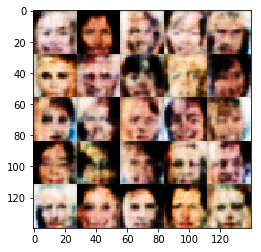

Epoch 1/6... Discriminator Loss: 0.5813... Generator Loss: 2.2485
Epoch 1/6... Discriminator Loss: 0.7760... Generator Loss: 2.1131
Epoch 1/6... Discriminator Loss: 1.1863... Generator Loss: 3.7799
Epoch 1/6... Discriminator Loss: 0.6219... Generator Loss: 1.6442
Epoch 1/6... Discriminator Loss: 0.5887... Generator Loss: 1.9233
Epoch 1/6... Discriminator Loss: 0.5437... Generator Loss: 2.3162
Epoch 1/6... Discriminator Loss: 2.2521... Generator Loss: 0.1939
Epoch 1/6... Discriminator Loss: 0.8708... Generator Loss: 1.2080
Epoch 1/6... Discriminator Loss: 0.9199... Generator Loss: 1.4285
Epoch 1/6... Discriminator Loss: 0.6582... Generator Loss: 1.5554
Epoch 1/6... Discriminator Loss: 0.7089... Generator Loss: 1.4684
Epoch 1/6... Discriminator Loss: 0.5779... Generator Loss: 3.4041
Epoch 1/6... Discriminator Loss: 0.6107... Generator Loss: 1.9785
Epoch 1/6... Discriminator Loss: 0.5126... Generator Loss: 2.5647
Epoch 1/6... Discriminator Loss: 0.5255... Generator Loss: 2.0112
Epoch 1/6.

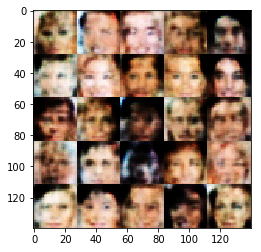

Epoch 1/6... Discriminator Loss: 0.5826... Generator Loss: 3.5082
Epoch 1/6... Discriminator Loss: 0.7375... Generator Loss: 1.2476
Epoch 1/6... Discriminator Loss: 0.7831... Generator Loss: 1.9132
Epoch 1/6... Discriminator Loss: 0.6838... Generator Loss: 1.3911
Epoch 1/6... Discriminator Loss: 0.6918... Generator Loss: 2.9107
Epoch 1/6... Discriminator Loss: 0.4632... Generator Loss: 3.1940
Epoch 1/6... Discriminator Loss: 0.4738... Generator Loss: 2.7451
Epoch 1/6... Discriminator Loss: 0.5028... Generator Loss: 2.2459
Epoch 1/6... Discriminator Loss: 0.5078... Generator Loss: 3.3498
Epoch 1/6... Discriminator Loss: 0.4577... Generator Loss: 4.3195
Epoch 1/6... Discriminator Loss: 0.5889... Generator Loss: 1.8196
Epoch 1/6... Discriminator Loss: 1.9971... Generator Loss: 0.2468
Epoch 1/6... Discriminator Loss: 0.7617... Generator Loss: 1.3121
Epoch 1/6... Discriminator Loss: 0.5287... Generator Loss: 2.1828
Epoch 1/6... Discriminator Loss: 0.6651... Generator Loss: 3.9959
Epoch 1/6.

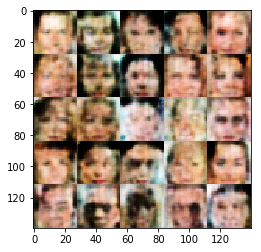

Epoch 1/6... Discriminator Loss: 0.7167... Generator Loss: 2.0533
Epoch 1/6... Discriminator Loss: 0.4680... Generator Loss: 2.9527
Epoch 1/6... Discriminator Loss: 0.7736... Generator Loss: 1.5789
Epoch 1/6... Discriminator Loss: 0.4605... Generator Loss: 2.6485
Epoch 1/6... Discriminator Loss: 0.6689... Generator Loss: 3.2241
Epoch 1/6... Discriminator Loss: 0.5402... Generator Loss: 2.4977
Epoch 1/6... Discriminator Loss: 0.5418... Generator Loss: 2.1313
Epoch 1/6... Discriminator Loss: 1.1491... Generator Loss: 0.9553
Epoch 1/6... Discriminator Loss: 1.5080... Generator Loss: 0.4306
Epoch 1/6... Discriminator Loss: 1.2936... Generator Loss: 1.2255
Epoch 1/6... Discriminator Loss: 0.5706... Generator Loss: 2.0598
Epoch 1/6... Discriminator Loss: 0.4784... Generator Loss: 2.6393
Epoch 1/6... Discriminator Loss: 0.9854... Generator Loss: 3.0159
Epoch 1/6... Discriminator Loss: 0.9454... Generator Loss: 0.9797
Epoch 1/6... Discriminator Loss: 0.6322... Generator Loss: 1.6340
Epoch 1/6.

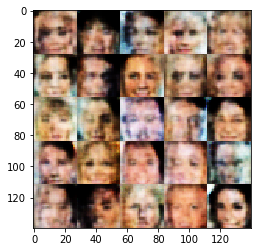

Epoch 1/6... Discriminator Loss: 0.6335... Generator Loss: 2.4215
Epoch 1/6... Discriminator Loss: 0.4535... Generator Loss: 3.0319
Epoch 1/6... Discriminator Loss: 1.5621... Generator Loss: 1.6453
Epoch 1/6... Discriminator Loss: 1.8405... Generator Loss: 0.3117
Epoch 1/6... Discriminator Loss: 0.9815... Generator Loss: 1.0027
Epoch 1/6... Discriminator Loss: 0.5551... Generator Loss: 2.0934
Epoch 1/6... Discriminator Loss: 0.9645... Generator Loss: 1.0004
Epoch 1/6... Discriminator Loss: 0.7908... Generator Loss: 1.3910
Epoch 1/6... Discriminator Loss: 0.7189... Generator Loss: 1.7596
Epoch 1/6... Discriminator Loss: 0.9712... Generator Loss: 0.8587
Epoch 1/6... Discriminator Loss: 0.9602... Generator Loss: 2.1894
Epoch 1/6... Discriminator Loss: 0.8980... Generator Loss: 1.5971
Epoch 1/6... Discriminator Loss: 0.5987... Generator Loss: 2.0035
Epoch 1/6... Discriminator Loss: 0.5940... Generator Loss: 1.8107
Epoch 1/6... Discriminator Loss: 0.7077... Generator Loss: 1.8727
Epoch 1/6.

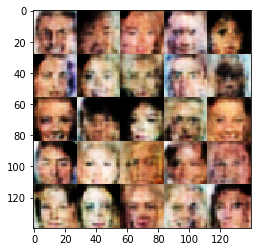

Epoch 1/6... Discriminator Loss: 1.0367... Generator Loss: 1.3157
Epoch 1/6... Discriminator Loss: 1.2481... Generator Loss: 0.6389
Epoch 1/6... Discriminator Loss: 1.0107... Generator Loss: 1.0529
Epoch 1/6... Discriminator Loss: 0.8203... Generator Loss: 1.1099
Epoch 1/6... Discriminator Loss: 1.1938... Generator Loss: 2.6888
Epoch 1/6... Discriminator Loss: 0.5306... Generator Loss: 2.6787
Epoch 1/6... Discriminator Loss: 0.7511... Generator Loss: 1.3209
Epoch 1/6... Discriminator Loss: 0.5334... Generator Loss: 2.4461
Epoch 1/6... Discriminator Loss: 0.5267... Generator Loss: 2.5726
Epoch 1/6... Discriminator Loss: 0.6284... Generator Loss: 2.1296
Epoch 1/6... Discriminator Loss: 1.6769... Generator Loss: 1.5560
Epoch 1/6... Discriminator Loss: 0.6411... Generator Loss: 1.7834
Epoch 1/6... Discriminator Loss: 1.0172... Generator Loss: 1.0427
Epoch 1/6... Discriminator Loss: 0.5855... Generator Loss: 2.1396
Epoch 1/6... Discriminator Loss: 0.7958... Generator Loss: 1.8177
Epoch 1/6.

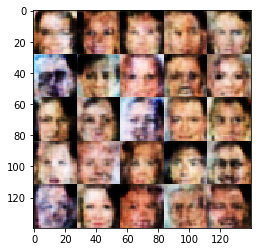

Epoch 1/6... Discriminator Loss: 0.5297... Generator Loss: 2.1638
Epoch 1/6... Discriminator Loss: 0.7312... Generator Loss: 1.4433
Epoch 1/6... Discriminator Loss: 0.6312... Generator Loss: 1.7886
Epoch 1/6... Discriminator Loss: 0.8072... Generator Loss: 1.4550
Epoch 1/6... Discriminator Loss: 0.6541... Generator Loss: 1.9037
Epoch 1/6... Discriminator Loss: 0.8572... Generator Loss: 2.5511
Epoch 1/6... Discriminator Loss: 1.9728... Generator Loss: 0.3212
Epoch 1/6... Discriminator Loss: 1.1095... Generator Loss: 0.7640
Epoch 1/6... Discriminator Loss: 0.8509... Generator Loss: 1.1214
Epoch 1/6... Discriminator Loss: 0.7072... Generator Loss: 2.6489
Epoch 1/6... Discriminator Loss: 0.9247... Generator Loss: 0.9357
Epoch 1/6... Discriminator Loss: 0.5917... Generator Loss: 2.0200
Epoch 1/6... Discriminator Loss: 0.7520... Generator Loss: 1.4037
Epoch 1/6... Discriminator Loss: 0.5575... Generator Loss: 2.5812
Epoch 1/6... Discriminator Loss: 0.6867... Generator Loss: 1.5353
Epoch 1/6.

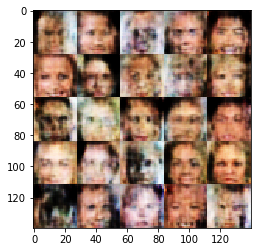

Epoch 1/6... Discriminator Loss: 0.8502... Generator Loss: 1.3942
Epoch 1/6... Discriminator Loss: 0.9776... Generator Loss: 1.1268
Epoch 1/6... Discriminator Loss: 0.7549... Generator Loss: 1.5594
Epoch 1/6... Discriminator Loss: 0.6873... Generator Loss: 1.5731
Epoch 1/6... Discriminator Loss: 0.8101... Generator Loss: 1.5397
Epoch 1/6... Discriminator Loss: 1.1099... Generator Loss: 1.2335
Epoch 1/6... Discriminator Loss: 2.2750... Generator Loss: 0.1972
Epoch 1/6... Discriminator Loss: 0.7361... Generator Loss: 1.5819
Epoch 1/6... Discriminator Loss: 1.0294... Generator Loss: 1.2774
Epoch 1/6... Discriminator Loss: 0.7407... Generator Loss: 1.7550
Epoch 1/6... Discriminator Loss: 0.7674... Generator Loss: 2.2831
Epoch 1/6... Discriminator Loss: 0.5882... Generator Loss: 2.1311
Epoch 1/6... Discriminator Loss: 0.8389... Generator Loss: 1.0760
Epoch 1/6... Discriminator Loss: 0.7599... Generator Loss: 2.2032
Epoch 1/6... Discriminator Loss: 1.0106... Generator Loss: 1.0631
Epoch 1/6.

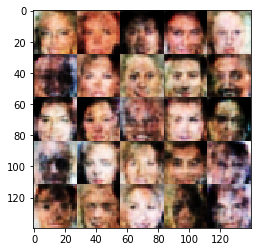

Epoch 2/6... Discriminator Loss: 0.7593... Generator Loss: 1.9962
Epoch 2/6... Discriminator Loss: 0.9049... Generator Loss: 1.2093
Epoch 2/6... Discriminator Loss: 0.8335... Generator Loss: 1.4371
Epoch 2/6... Discriminator Loss: 0.7733... Generator Loss: 1.7502
Epoch 2/6... Discriminator Loss: 0.8166... Generator Loss: 1.4429
Epoch 2/6... Discriminator Loss: 0.5294... Generator Loss: 2.6434
Epoch 2/6... Discriminator Loss: 1.2441... Generator Loss: 0.8453
Epoch 2/6... Discriminator Loss: 1.0286... Generator Loss: 0.9186
Epoch 2/6... Discriminator Loss: 1.5672... Generator Loss: 0.4012
Epoch 2/6... Discriminator Loss: 0.7799... Generator Loss: 1.5436
Epoch 2/6... Discriminator Loss: 0.6201... Generator Loss: 2.3793
Epoch 2/6... Discriminator Loss: 1.2100... Generator Loss: 1.0882
Epoch 2/6... Discriminator Loss: 1.1244... Generator Loss: 1.3387
Epoch 2/6... Discriminator Loss: 0.7923... Generator Loss: 1.6670
Epoch 2/6... Discriminator Loss: 1.7023... Generator Loss: 1.9971
Epoch 2/6.

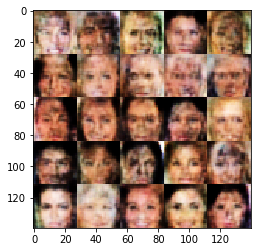

Epoch 2/6... Discriminator Loss: 0.6599... Generator Loss: 2.3666
Epoch 2/6... Discriminator Loss: 0.7672... Generator Loss: 2.1803
Epoch 2/6... Discriminator Loss: 1.1544... Generator Loss: 0.6777
Epoch 2/6... Discriminator Loss: 0.8620... Generator Loss: 1.1185
Epoch 2/6... Discriminator Loss: 1.0393... Generator Loss: 1.0783
Epoch 2/6... Discriminator Loss: 1.0417... Generator Loss: 0.9310
Epoch 2/6... Discriminator Loss: 0.9882... Generator Loss: 1.1989
Epoch 2/6... Discriminator Loss: 0.9122... Generator Loss: 1.4741
Epoch 2/6... Discriminator Loss: 0.7711... Generator Loss: 2.2591
Epoch 2/6... Discriminator Loss: 1.0577... Generator Loss: 1.0291
Epoch 2/6... Discriminator Loss: 1.5929... Generator Loss: 1.4896
Epoch 2/6... Discriminator Loss: 1.7503... Generator Loss: 0.3287
Epoch 2/6... Discriminator Loss: 0.8153... Generator Loss: 1.3277
Epoch 2/6... Discriminator Loss: 1.0158... Generator Loss: 1.5034
Epoch 2/6... Discriminator Loss: 0.8274... Generator Loss: 1.8125
Epoch 2/6.

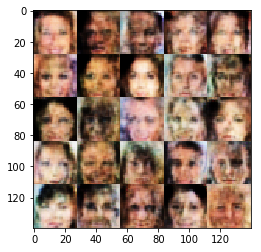

Epoch 2/6... Discriminator Loss: 1.2531... Generator Loss: 0.6464
Epoch 2/6... Discriminator Loss: 0.4897... Generator Loss: 2.7066
Epoch 2/6... Discriminator Loss: 1.0738... Generator Loss: 0.9157
Epoch 2/6... Discriminator Loss: 2.0612... Generator Loss: 0.2521
Epoch 2/6... Discriminator Loss: 0.7986... Generator Loss: 1.3071
Epoch 2/6... Discriminator Loss: 0.9326... Generator Loss: 1.0319
Epoch 2/6... Discriminator Loss: 0.8832... Generator Loss: 1.1833
Epoch 2/6... Discriminator Loss: 0.9938... Generator Loss: 0.9843
Epoch 2/6... Discriminator Loss: 1.0577... Generator Loss: 1.4200
Epoch 2/6... Discriminator Loss: 1.2644... Generator Loss: 0.7869
Epoch 2/6... Discriminator Loss: 1.1012... Generator Loss: 0.8002
Epoch 2/6... Discriminator Loss: 0.9666... Generator Loss: 0.9741
Epoch 2/6... Discriminator Loss: 0.7600... Generator Loss: 1.2741
Epoch 2/6... Discriminator Loss: 1.1086... Generator Loss: 2.0121
Epoch 2/6... Discriminator Loss: 1.6486... Generator Loss: 0.6053
Epoch 2/6.

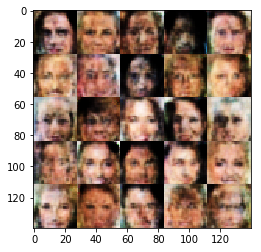

Epoch 2/6... Discriminator Loss: 0.7833... Generator Loss: 2.3790
Epoch 2/6... Discriminator Loss: 1.6874... Generator Loss: 1.9919
Epoch 2/6... Discriminator Loss: 0.8425... Generator Loss: 1.6242
Epoch 2/6... Discriminator Loss: 1.2523... Generator Loss: 1.0818
Epoch 2/6... Discriminator Loss: 1.2462... Generator Loss: 1.2961
Epoch 2/6... Discriminator Loss: 1.0304... Generator Loss: 0.8878
Epoch 2/6... Discriminator Loss: 1.4002... Generator Loss: 0.4988
Epoch 2/6... Discriminator Loss: 1.0042... Generator Loss: 1.1336
Epoch 2/6... Discriminator Loss: 0.8471... Generator Loss: 1.3973
Epoch 2/6... Discriminator Loss: 0.8829... Generator Loss: 1.2318
Epoch 2/6... Discriminator Loss: 0.6597... Generator Loss: 1.9718
Epoch 2/6... Discriminator Loss: 0.7730... Generator Loss: 1.5204
Epoch 2/6... Discriminator Loss: 0.9817... Generator Loss: 1.1550
Epoch 2/6... Discriminator Loss: 1.2154... Generator Loss: 0.6302
Epoch 2/6... Discriminator Loss: 0.8167... Generator Loss: 1.5181
Epoch 2/6.

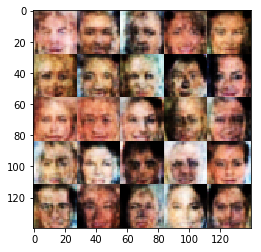

Epoch 2/6... Discriminator Loss: 1.2687... Generator Loss: 1.2800
Epoch 2/6... Discriminator Loss: 1.0355... Generator Loss: 0.9381
Epoch 2/6... Discriminator Loss: 0.8156... Generator Loss: 1.2417
Epoch 2/6... Discriminator Loss: 1.2919... Generator Loss: 1.7745
Epoch 2/6... Discriminator Loss: 0.8713... Generator Loss: 1.5431
Epoch 2/6... Discriminator Loss: 0.6315... Generator Loss: 2.1184
Epoch 2/6... Discriminator Loss: 1.0699... Generator Loss: 1.1334
Epoch 2/6... Discriminator Loss: 0.9858... Generator Loss: 1.2468
Epoch 2/6... Discriminator Loss: 0.9441... Generator Loss: 1.0359
Epoch 2/6... Discriminator Loss: 0.8630... Generator Loss: 1.3011
Epoch 2/6... Discriminator Loss: 1.1487... Generator Loss: 1.2187
Epoch 2/6... Discriminator Loss: 1.4368... Generator Loss: 1.9598
Epoch 2/6... Discriminator Loss: 0.8113... Generator Loss: 1.2289
Epoch 2/6... Discriminator Loss: 1.2391... Generator Loss: 0.8667
Epoch 2/6... Discriminator Loss: 1.4479... Generator Loss: 0.8586
Epoch 2/6.

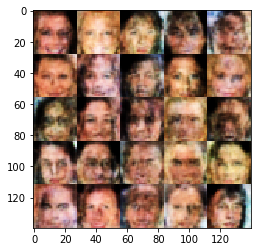

Epoch 2/6... Discriminator Loss: 0.9318... Generator Loss: 1.2914
Epoch 2/6... Discriminator Loss: 1.2080... Generator Loss: 1.9915
Epoch 2/6... Discriminator Loss: 1.3423... Generator Loss: 2.4637
Epoch 2/6... Discriminator Loss: 1.3049... Generator Loss: 1.9281
Epoch 2/6... Discriminator Loss: 1.3347... Generator Loss: 0.6130
Epoch 2/6... Discriminator Loss: 0.9844... Generator Loss: 1.5680
Epoch 2/6... Discriminator Loss: 1.0210... Generator Loss: 0.9776
Epoch 2/6... Discriminator Loss: 1.2053... Generator Loss: 0.7467
Epoch 2/6... Discriminator Loss: 0.9975... Generator Loss: 1.2111
Epoch 2/6... Discriminator Loss: 1.0413... Generator Loss: 1.5951
Epoch 2/6... Discriminator Loss: 1.0907... Generator Loss: 0.8954
Epoch 2/6... Discriminator Loss: 1.0122... Generator Loss: 0.8483
Epoch 2/6... Discriminator Loss: 1.1122... Generator Loss: 0.8383
Epoch 2/6... Discriminator Loss: 0.8551... Generator Loss: 1.5104
Epoch 2/6... Discriminator Loss: 0.7417... Generator Loss: 2.1823
Epoch 2/6.

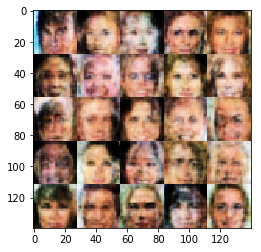

Epoch 2/6... Discriminator Loss: 1.2287... Generator Loss: 1.1196
Epoch 2/6... Discriminator Loss: 0.8555... Generator Loss: 2.8253
Epoch 2/6... Discriminator Loss: 1.0994... Generator Loss: 1.0822
Epoch 2/6... Discriminator Loss: 0.6818... Generator Loss: 2.2784
Epoch 2/6... Discriminator Loss: 1.2252... Generator Loss: 0.6532
Epoch 2/6... Discriminator Loss: 1.1158... Generator Loss: 0.8398
Epoch 2/6... Discriminator Loss: 0.7288... Generator Loss: 1.4390
Epoch 2/6... Discriminator Loss: 1.7039... Generator Loss: 0.3825
Epoch 2/6... Discriminator Loss: 1.1194... Generator Loss: 1.0311
Epoch 2/6... Discriminator Loss: 0.7621... Generator Loss: 1.7892
Epoch 2/6... Discriminator Loss: 1.1974... Generator Loss: 1.2825
Epoch 2/6... Discriminator Loss: 0.9404... Generator Loss: 1.0903
Epoch 2/6... Discriminator Loss: 0.9327... Generator Loss: 1.0614
Epoch 2/6... Discriminator Loss: 0.8974... Generator Loss: 1.3935
Epoch 2/6... Discriminator Loss: 0.8681... Generator Loss: 1.5806
Epoch 2/6.

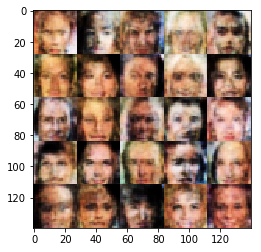

Epoch 2/6... Discriminator Loss: 1.2739... Generator Loss: 0.7192
Epoch 2/6... Discriminator Loss: 1.1892... Generator Loss: 1.3035
Epoch 2/6... Discriminator Loss: 0.9994... Generator Loss: 1.0937
Epoch 2/6... Discriminator Loss: 0.8677... Generator Loss: 1.3307
Epoch 2/6... Discriminator Loss: 1.0717... Generator Loss: 0.9794
Epoch 2/6... Discriminator Loss: 0.6265... Generator Loss: 2.7946
Epoch 2/6... Discriminator Loss: 1.1469... Generator Loss: 1.4570
Epoch 2/6... Discriminator Loss: 1.1254... Generator Loss: 1.9497
Epoch 2/6... Discriminator Loss: 1.1425... Generator Loss: 0.7395
Epoch 2/6... Discriminator Loss: 1.1193... Generator Loss: 0.8317
Epoch 2/6... Discriminator Loss: 1.0031... Generator Loss: 0.8897
Epoch 2/6... Discriminator Loss: 1.1025... Generator Loss: 1.0209
Epoch 2/6... Discriminator Loss: 1.0842... Generator Loss: 1.2522
Epoch 2/6... Discriminator Loss: 1.0885... Generator Loss: 1.5743
Epoch 2/6... Discriminator Loss: 1.2682... Generator Loss: 0.6489
Epoch 2/6.

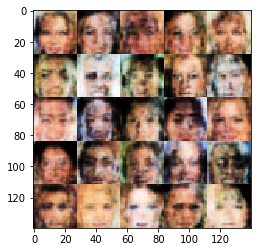

Epoch 2/6... Discriminator Loss: 1.1876... Generator Loss: 1.5157
Epoch 2/6... Discriminator Loss: 0.8296... Generator Loss: 1.3883
Epoch 2/6... Discriminator Loss: 1.1142... Generator Loss: 0.8226
Epoch 2/6... Discriminator Loss: 0.9935... Generator Loss: 1.6288
Epoch 2/6... Discriminator Loss: 1.0988... Generator Loss: 0.9579
Epoch 2/6... Discriminator Loss: 0.6282... Generator Loss: 2.8270
Epoch 2/6... Discriminator Loss: 1.1400... Generator Loss: 0.8835
Epoch 2/6... Discriminator Loss: 1.1539... Generator Loss: 0.7612
Epoch 2/6... Discriminator Loss: 1.0060... Generator Loss: 0.9083
Epoch 2/6... Discriminator Loss: 0.8733... Generator Loss: 1.3721
Epoch 2/6... Discriminator Loss: 1.0808... Generator Loss: 0.8716
Epoch 2/6... Discriminator Loss: 1.1365... Generator Loss: 0.9046
Epoch 2/6... Discriminator Loss: 1.1153... Generator Loss: 2.0699
Epoch 2/6... Discriminator Loss: 1.1224... Generator Loss: 1.4704
Epoch 2/6... Discriminator Loss: 1.1804... Generator Loss: 0.7273
Epoch 2/6.

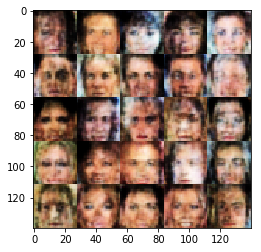

Epoch 2/6... Discriminator Loss: 1.0434... Generator Loss: 1.0752
Epoch 2/6... Discriminator Loss: 1.7622... Generator Loss: 2.3709
Epoch 2/6... Discriminator Loss: 0.7316... Generator Loss: 2.3561
Epoch 2/6... Discriminator Loss: 1.2742... Generator Loss: 0.8528
Epoch 2/6... Discriminator Loss: 1.2687... Generator Loss: 0.6188
Epoch 2/6... Discriminator Loss: 1.1692... Generator Loss: 0.9282
Epoch 2/6... Discriminator Loss: 1.1715... Generator Loss: 1.1231
Epoch 2/6... Discriminator Loss: 1.2149... Generator Loss: 1.1116
Epoch 2/6... Discriminator Loss: 0.8608... Generator Loss: 1.1973
Epoch 2/6... Discriminator Loss: 0.7532... Generator Loss: 1.9781
Epoch 2/6... Discriminator Loss: 1.1096... Generator Loss: 0.8119
Epoch 2/6... Discriminator Loss: 0.6831... Generator Loss: 1.9551
Epoch 2/6... Discriminator Loss: 1.0743... Generator Loss: 1.3829
Epoch 2/6... Discriminator Loss: 1.1054... Generator Loss: 0.8971
Epoch 2/6... Discriminator Loss: 0.9507... Generator Loss: 1.4658
Epoch 2/6.

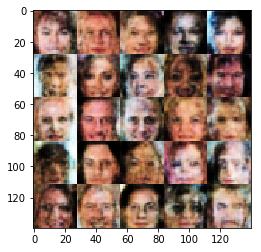

Epoch 2/6... Discriminator Loss: 1.1042... Generator Loss: 1.4608
Epoch 2/6... Discriminator Loss: 0.7846... Generator Loss: 1.6120
Epoch 2/6... Discriminator Loss: 1.1490... Generator Loss: 1.0302
Epoch 2/6... Discriminator Loss: 1.0574... Generator Loss: 1.5888
Epoch 2/6... Discriminator Loss: 1.1994... Generator Loss: 0.8564
Epoch 2/6... Discriminator Loss: 0.8041... Generator Loss: 2.0785
Epoch 2/6... Discriminator Loss: 0.9603... Generator Loss: 1.5698
Epoch 2/6... Discriminator Loss: 0.7450... Generator Loss: 2.2969
Epoch 2/6... Discriminator Loss: 1.0716... Generator Loss: 1.0487
Epoch 2/6... Discriminator Loss: 1.0529... Generator Loss: 1.0888
Epoch 2/6... Discriminator Loss: 1.0417... Generator Loss: 0.9193
Epoch 2/6... Discriminator Loss: 0.8271... Generator Loss: 1.4453
Epoch 2/6... Discriminator Loss: 1.0219... Generator Loss: 1.3373
Epoch 2/6... Discriminator Loss: 1.4292... Generator Loss: 0.5463
Epoch 2/6... Discriminator Loss: 1.2140... Generator Loss: 1.6522
Epoch 2/6.

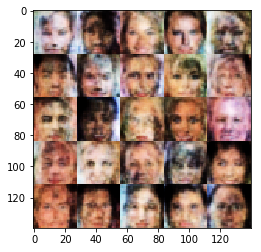

Epoch 2/6... Discriminator Loss: 1.0749... Generator Loss: 0.9800
Epoch 2/6... Discriminator Loss: 0.9643... Generator Loss: 1.0868
Epoch 2/6... Discriminator Loss: 1.3797... Generator Loss: 0.5630
Epoch 2/6... Discriminator Loss: 0.7278... Generator Loss: 1.5926
Epoch 2/6... Discriminator Loss: 1.0412... Generator Loss: 0.9254
Epoch 2/6... Discriminator Loss: 0.8085... Generator Loss: 1.4620
Epoch 2/6... Discriminator Loss: 1.3859... Generator Loss: 0.5057
Epoch 2/6... Discriminator Loss: 0.7770... Generator Loss: 2.3296
Epoch 2/6... Discriminator Loss: 1.1867... Generator Loss: 0.6982
Epoch 2/6... Discriminator Loss: 1.0328... Generator Loss: 1.3421
Epoch 2/6... Discriminator Loss: 0.9522... Generator Loss: 2.2916
Epoch 2/6... Discriminator Loss: 0.8143... Generator Loss: 1.3045
Epoch 2/6... Discriminator Loss: 1.0944... Generator Loss: 1.0950
Epoch 2/6... Discriminator Loss: 0.9293... Generator Loss: 1.3642
Epoch 2/6... Discriminator Loss: 1.1029... Generator Loss: 0.8010
Epoch 2/6.

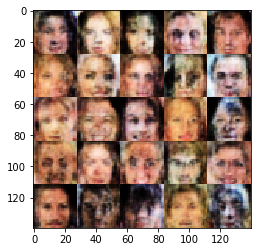

Epoch 2/6... Discriminator Loss: 1.2929... Generator Loss: 1.5614
Epoch 2/6... Discriminator Loss: 1.1570... Generator Loss: 0.9173
Epoch 2/6... Discriminator Loss: 1.0266... Generator Loss: 1.3070
Epoch 2/6... Discriminator Loss: 1.2071... Generator Loss: 0.7055
Epoch 2/6... Discriminator Loss: 1.0526... Generator Loss: 1.0176
Epoch 2/6... Discriminator Loss: 1.0787... Generator Loss: 0.9334
Epoch 2/6... Discriminator Loss: 1.2080... Generator Loss: 1.2236
Epoch 2/6... Discriminator Loss: 0.5538... Generator Loss: 2.6310
Epoch 2/6... Discriminator Loss: 1.4248... Generator Loss: 1.9978
Epoch 2/6... Discriminator Loss: 1.0428... Generator Loss: 1.1324
Epoch 2/6... Discriminator Loss: 0.6313... Generator Loss: 2.3392
Epoch 2/6... Discriminator Loss: 1.1797... Generator Loss: 0.8340
Epoch 2/6... Discriminator Loss: 1.6783... Generator Loss: 0.3584
Epoch 2/6... Discriminator Loss: 0.9806... Generator Loss: 1.3133
Epoch 2/6... Discriminator Loss: 1.0658... Generator Loss: 0.9483
Epoch 2/6.

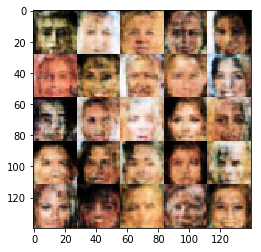

Epoch 2/6... Discriminator Loss: 1.1686... Generator Loss: 2.0864
Epoch 2/6... Discriminator Loss: 0.9762... Generator Loss: 1.3922
Epoch 2/6... Discriminator Loss: 1.2016... Generator Loss: 0.8769
Epoch 2/6... Discriminator Loss: 1.1933... Generator Loss: 0.6887
Epoch 2/6... Discriminator Loss: 1.1281... Generator Loss: 0.8062
Epoch 2/6... Discriminator Loss: 1.0504... Generator Loss: 1.0787
Epoch 2/6... Discriminator Loss: 0.8445... Generator Loss: 1.2558
Epoch 2/6... Discriminator Loss: 0.8281... Generator Loss: 2.2581
Epoch 2/6... Discriminator Loss: 0.9983... Generator Loss: 1.7611
Epoch 2/6... Discriminator Loss: 0.9561... Generator Loss: 1.5797
Epoch 2/6... Discriminator Loss: 1.1732... Generator Loss: 0.9587
Epoch 2/6... Discriminator Loss: 1.3062... Generator Loss: 0.7265
Epoch 2/6... Discriminator Loss: 0.9490... Generator Loss: 1.6703
Epoch 2/6... Discriminator Loss: 1.1962... Generator Loss: 0.8019
Epoch 2/6... Discriminator Loss: 1.1586... Generator Loss: 0.8643
Epoch 2/6.

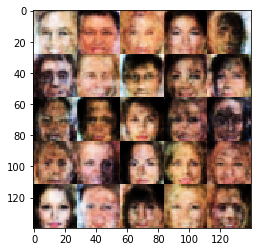

Epoch 2/6... Discriminator Loss: 1.0735... Generator Loss: 1.1224
Epoch 2/6... Discriminator Loss: 0.9409... Generator Loss: 1.4364
Epoch 2/6... Discriminator Loss: 1.1920... Generator Loss: 1.1882
Epoch 2/6... Discriminator Loss: 0.9842... Generator Loss: 1.0476
Epoch 2/6... Discriminator Loss: 0.7304... Generator Loss: 2.1566
Epoch 2/6... Discriminator Loss: 1.2730... Generator Loss: 0.7132
Epoch 2/6... Discriminator Loss: 0.8570... Generator Loss: 1.2315
Epoch 2/6... Discriminator Loss: 0.9586... Generator Loss: 1.3584
Epoch 2/6... Discriminator Loss: 1.2622... Generator Loss: 0.6812
Epoch 2/6... Discriminator Loss: 1.1496... Generator Loss: 0.7874
Epoch 2/6... Discriminator Loss: 1.2058... Generator Loss: 0.8006
Epoch 2/6... Discriminator Loss: 1.0220... Generator Loss: 1.1614
Epoch 2/6... Discriminator Loss: 0.8047... Generator Loss: 1.5384
Epoch 2/6... Discriminator Loss: 1.0683... Generator Loss: 1.7656
Epoch 2/6... Discriminator Loss: 1.1623... Generator Loss: 0.9164
Epoch 2/6.

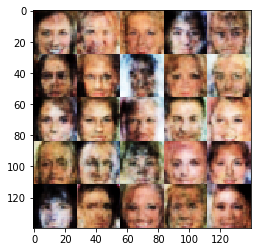

Epoch 2/6... Discriminator Loss: 1.1662... Generator Loss: 1.1188
Epoch 2/6... Discriminator Loss: 0.7681... Generator Loss: 1.6169
Epoch 2/6... Discriminator Loss: 1.1437... Generator Loss: 1.1268
Epoch 2/6... Discriminator Loss: 0.8240... Generator Loss: 1.7158
Epoch 2/6... Discriminator Loss: 1.0425... Generator Loss: 1.0840
Epoch 2/6... Discriminator Loss: 0.9538... Generator Loss: 1.2759
Epoch 2/6... Discriminator Loss: 1.2203... Generator Loss: 1.1308
Epoch 2/6... Discriminator Loss: 1.1047... Generator Loss: 1.2535
Epoch 2/6... Discriminator Loss: 0.9533... Generator Loss: 1.2887
Epoch 2/6... Discriminator Loss: 0.9745... Generator Loss: 0.9431
Epoch 2/6... Discriminator Loss: 1.0018... Generator Loss: 1.2652
Epoch 2/6... Discriminator Loss: 1.1346... Generator Loss: 0.9049
Epoch 3/6... Discriminator Loss: 0.9224... Generator Loss: 1.5986
Epoch 3/6... Discriminator Loss: 1.2207... Generator Loss: 1.8116
Epoch 3/6... Discriminator Loss: 1.0563... Generator Loss: 2.1704
Epoch 3/6.

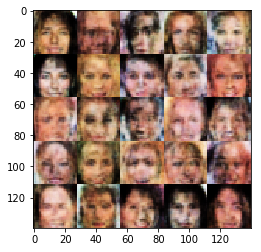

Epoch 3/6... Discriminator Loss: 1.2538... Generator Loss: 0.7157
Epoch 3/6... Discriminator Loss: 1.1668... Generator Loss: 1.1208
Epoch 3/6... Discriminator Loss: 1.0182... Generator Loss: 1.6229
Epoch 3/6... Discriminator Loss: 1.1943... Generator Loss: 0.8912
Epoch 3/6... Discriminator Loss: 1.1282... Generator Loss: 1.0724
Epoch 3/6... Discriminator Loss: 0.9615... Generator Loss: 1.0812
Epoch 3/6... Discriminator Loss: 1.0130... Generator Loss: 1.2038
Epoch 3/6... Discriminator Loss: 1.0326... Generator Loss: 1.6425
Epoch 3/6... Discriminator Loss: 0.8138... Generator Loss: 1.8556
Epoch 3/6... Discriminator Loss: 1.1302... Generator Loss: 0.9629
Epoch 3/6... Discriminator Loss: 1.0239... Generator Loss: 0.9764
Epoch 3/6... Discriminator Loss: 1.0841... Generator Loss: 1.1749
Epoch 3/6... Discriminator Loss: 1.1374... Generator Loss: 1.0333
Epoch 3/6... Discriminator Loss: 1.1102... Generator Loss: 0.9442
Epoch 3/6... Discriminator Loss: 1.1316... Generator Loss: 1.5555
Epoch 3/6.

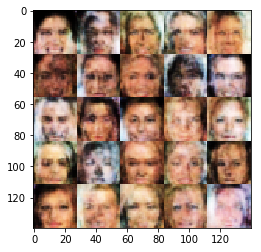

Epoch 3/6... Discriminator Loss: 1.0785... Generator Loss: 1.0866
Epoch 3/6... Discriminator Loss: 1.2757... Generator Loss: 0.6157
Epoch 3/6... Discriminator Loss: 1.0058... Generator Loss: 1.0337
Epoch 3/6... Discriminator Loss: 0.9344... Generator Loss: 1.2992
Epoch 3/6... Discriminator Loss: 1.3817... Generator Loss: 0.5988
Epoch 3/6... Discriminator Loss: 1.1639... Generator Loss: 0.7304
Epoch 3/6... Discriminator Loss: 1.2550... Generator Loss: 1.2339
Epoch 3/6... Discriminator Loss: 1.3624... Generator Loss: 0.5432
Epoch 3/6... Discriminator Loss: 1.2187... Generator Loss: 0.9867
Epoch 3/6... Discriminator Loss: 1.1312... Generator Loss: 1.3252
Epoch 3/6... Discriminator Loss: 1.0219... Generator Loss: 1.6430
Epoch 3/6... Discriminator Loss: 1.2071... Generator Loss: 1.1519
Epoch 3/6... Discriminator Loss: 1.0574... Generator Loss: 1.1027
Epoch 3/6... Discriminator Loss: 1.0776... Generator Loss: 0.8870
Epoch 3/6... Discriminator Loss: 1.1829... Generator Loss: 1.5807
Epoch 3/6.

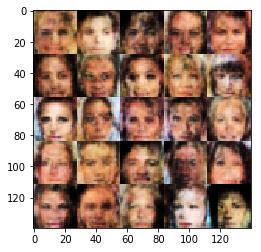

Epoch 3/6... Discriminator Loss: 1.3317... Generator Loss: 1.2147
Epoch 3/6... Discriminator Loss: 1.1734... Generator Loss: 1.1516
Epoch 3/6... Discriminator Loss: 1.1531... Generator Loss: 0.9587
Epoch 3/6... Discriminator Loss: 1.2026... Generator Loss: 0.8670
Epoch 3/6... Discriminator Loss: 0.8487... Generator Loss: 1.3151
Epoch 3/6... Discriminator Loss: 1.1030... Generator Loss: 1.0003
Epoch 3/6... Discriminator Loss: 1.1565... Generator Loss: 0.8928
Epoch 3/6... Discriminator Loss: 1.2043... Generator Loss: 0.8602
Epoch 3/6... Discriminator Loss: 1.1631... Generator Loss: 1.1269
Epoch 3/6... Discriminator Loss: 0.6614... Generator Loss: 3.2999
Epoch 3/6... Discriminator Loss: 1.0898... Generator Loss: 0.9930
Epoch 3/6... Discriminator Loss: 1.2232... Generator Loss: 1.1610
Epoch 3/6... Discriminator Loss: 1.1652... Generator Loss: 0.8564
Epoch 3/6... Discriminator Loss: 0.9051... Generator Loss: 1.4532
Epoch 3/6... Discriminator Loss: 1.0639... Generator Loss: 0.9231
Epoch 3/6.

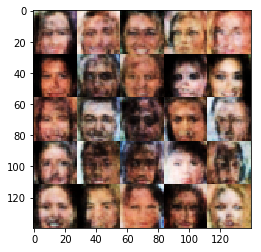

Epoch 3/6... Discriminator Loss: 1.2257... Generator Loss: 1.1975
Epoch 3/6... Discriminator Loss: 1.1793... Generator Loss: 0.8770
Epoch 3/6... Discriminator Loss: 1.2307... Generator Loss: 0.7866
Epoch 3/6... Discriminator Loss: 1.1874... Generator Loss: 0.8444
Epoch 3/6... Discriminator Loss: 1.2024... Generator Loss: 0.6989
Epoch 3/6... Discriminator Loss: 1.1013... Generator Loss: 0.8510
Epoch 3/6... Discriminator Loss: 1.2190... Generator Loss: 0.9219
Epoch 3/6... Discriminator Loss: 1.3641... Generator Loss: 0.5887
Epoch 3/6... Discriminator Loss: 1.0671... Generator Loss: 1.1183
Epoch 3/6... Discriminator Loss: 1.0947... Generator Loss: 0.8083
Epoch 3/6... Discriminator Loss: 1.0761... Generator Loss: 0.9993
Epoch 3/6... Discriminator Loss: 1.0733... Generator Loss: 1.0467
Epoch 3/6... Discriminator Loss: 1.0446... Generator Loss: 1.0194
Epoch 3/6... Discriminator Loss: 1.1742... Generator Loss: 0.8526
Epoch 3/6... Discriminator Loss: 1.1404... Generator Loss: 1.1382
Epoch 3/6.

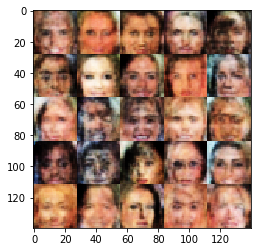

Epoch 3/6... Discriminator Loss: 1.1353... Generator Loss: 1.5154
Epoch 3/6... Discriminator Loss: 1.1783... Generator Loss: 1.0395
Epoch 3/6... Discriminator Loss: 1.2389... Generator Loss: 0.6907
Epoch 3/6... Discriminator Loss: 1.0605... Generator Loss: 1.1065
Epoch 3/6... Discriminator Loss: 1.1086... Generator Loss: 0.8238
Epoch 3/6... Discriminator Loss: 1.1650... Generator Loss: 0.7077
Epoch 3/6... Discriminator Loss: 1.1397... Generator Loss: 1.0978
Epoch 3/6... Discriminator Loss: 1.0575... Generator Loss: 1.2023
Epoch 3/6... Discriminator Loss: 1.0394... Generator Loss: 1.0576
Epoch 3/6... Discriminator Loss: 0.9840... Generator Loss: 1.1762
Epoch 3/6... Discriminator Loss: 1.1739... Generator Loss: 1.0877
Epoch 3/6... Discriminator Loss: 1.2989... Generator Loss: 0.7776
Epoch 3/6... Discriminator Loss: 1.0388... Generator Loss: 0.8485
Epoch 3/6... Discriminator Loss: 1.0433... Generator Loss: 1.0096
Epoch 3/6... Discriminator Loss: 1.1038... Generator Loss: 1.5420
Epoch 3/6.

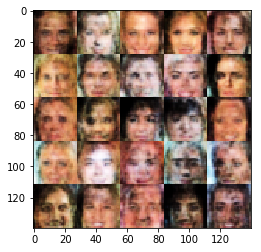

Epoch 3/6... Discriminator Loss: 1.4587... Generator Loss: 1.6097
Epoch 3/6... Discriminator Loss: 0.9799... Generator Loss: 1.4237
Epoch 3/6... Discriminator Loss: 1.0995... Generator Loss: 0.9500
Epoch 3/6... Discriminator Loss: 1.1085... Generator Loss: 0.9759
Epoch 3/6... Discriminator Loss: 1.1780... Generator Loss: 1.0273
Epoch 3/6... Discriminator Loss: 1.1546... Generator Loss: 0.9307
Epoch 3/6... Discriminator Loss: 1.1145... Generator Loss: 1.1592
Epoch 3/6... Discriminator Loss: 1.2515... Generator Loss: 0.7380
Epoch 3/6... Discriminator Loss: 1.0760... Generator Loss: 1.2051
Epoch 3/6... Discriminator Loss: 1.0626... Generator Loss: 1.1990
Epoch 3/6... Discriminator Loss: 1.1500... Generator Loss: 1.3392
Epoch 3/6... Discriminator Loss: 0.7437... Generator Loss: 1.8924
Epoch 3/6... Discriminator Loss: 1.2109... Generator Loss: 1.0533
Epoch 3/6... Discriminator Loss: 1.1335... Generator Loss: 1.1819
Epoch 3/6... Discriminator Loss: 0.9832... Generator Loss: 1.0203
Epoch 3/6.

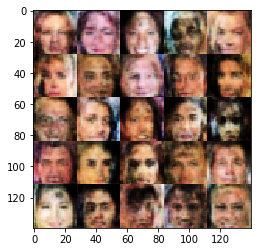

Epoch 3/6... Discriminator Loss: 1.1607... Generator Loss: 0.9913
Epoch 3/6... Discriminator Loss: 1.2579... Generator Loss: 1.0090
Epoch 3/6... Discriminator Loss: 1.1182... Generator Loss: 0.8786
Epoch 3/6... Discriminator Loss: 1.1360... Generator Loss: 0.8583
Epoch 3/6... Discriminator Loss: 1.3078... Generator Loss: 0.6147
Epoch 3/6... Discriminator Loss: 1.0333... Generator Loss: 1.2512
Epoch 3/6... Discriminator Loss: 1.1625... Generator Loss: 0.7974
Epoch 3/6... Discriminator Loss: 1.1587... Generator Loss: 1.1239
Epoch 3/6... Discriminator Loss: 1.0554... Generator Loss: 1.3100
Epoch 3/6... Discriminator Loss: 1.0461... Generator Loss: 1.2480
Epoch 3/6... Discriminator Loss: 1.3385... Generator Loss: 0.6262
Epoch 3/6... Discriminator Loss: 1.1860... Generator Loss: 1.0180
Epoch 3/6... Discriminator Loss: 1.2640... Generator Loss: 0.6949
Epoch 3/6... Discriminator Loss: 1.0656... Generator Loss: 1.2406
Epoch 3/6... Discriminator Loss: 1.1405... Generator Loss: 1.0749
Epoch 3/6.

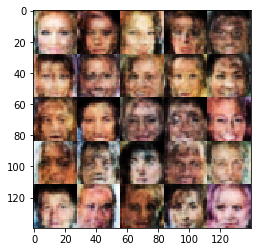

Epoch 3/6... Discriminator Loss: 0.8678... Generator Loss: 1.2392
Epoch 3/6... Discriminator Loss: 1.1772... Generator Loss: 1.0464
Epoch 3/6... Discriminator Loss: 1.2003... Generator Loss: 0.7355
Epoch 3/6... Discriminator Loss: 1.3110... Generator Loss: 1.5014
Epoch 3/6... Discriminator Loss: 1.1475... Generator Loss: 0.9019
Epoch 3/6... Discriminator Loss: 1.2449... Generator Loss: 0.8242
Epoch 3/6... Discriminator Loss: 1.1062... Generator Loss: 1.1619
Epoch 3/6... Discriminator Loss: 1.0288... Generator Loss: 1.3439
Epoch 3/6... Discriminator Loss: 1.0716... Generator Loss: 1.2751
Epoch 3/6... Discriminator Loss: 1.2152... Generator Loss: 1.3384
Epoch 3/6... Discriminator Loss: 1.2387... Generator Loss: 1.6060
Epoch 3/6... Discriminator Loss: 1.1613... Generator Loss: 0.7647
Epoch 3/6... Discriminator Loss: 1.1161... Generator Loss: 1.0175
Epoch 3/6... Discriminator Loss: 1.3052... Generator Loss: 1.8902
Epoch 3/6... Discriminator Loss: 1.1037... Generator Loss: 1.3429
Epoch 3/6.

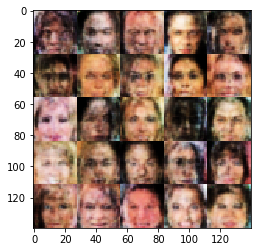

Epoch 3/6... Discriminator Loss: 1.2554... Generator Loss: 0.8287
Epoch 3/6... Discriminator Loss: 1.4371... Generator Loss: 0.5578
Epoch 3/6... Discriminator Loss: 1.3005... Generator Loss: 1.1048
Epoch 3/6... Discriminator Loss: 1.1596... Generator Loss: 0.7873
Epoch 3/6... Discriminator Loss: 1.0593... Generator Loss: 1.0219
Epoch 3/6... Discriminator Loss: 1.1756... Generator Loss: 0.9314
Epoch 3/6... Discriminator Loss: 0.7132... Generator Loss: 1.9768
Epoch 3/6... Discriminator Loss: 1.1512... Generator Loss: 1.2580
Epoch 3/6... Discriminator Loss: 1.1462... Generator Loss: 1.1181
Epoch 3/6... Discriminator Loss: 1.2166... Generator Loss: 0.9480
Epoch 3/6... Discriminator Loss: 1.1550... Generator Loss: 1.1770
Epoch 3/6... Discriminator Loss: 0.8401... Generator Loss: 1.6116
Epoch 3/6... Discriminator Loss: 1.1648... Generator Loss: 1.2595
Epoch 3/6... Discriminator Loss: 1.0082... Generator Loss: 1.0825
Epoch 3/6... Discriminator Loss: 1.1406... Generator Loss: 0.8378
Epoch 3/6.

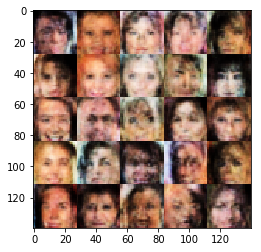

Epoch 3/6... Discriminator Loss: 1.2401... Generator Loss: 1.4865
Epoch 3/6... Discriminator Loss: 1.0910... Generator Loss: 1.4998
Epoch 3/6... Discriminator Loss: 1.0714... Generator Loss: 0.9565
Epoch 3/6... Discriminator Loss: 0.9664... Generator Loss: 1.5741
Epoch 3/6... Discriminator Loss: 1.1854... Generator Loss: 0.9896
Epoch 3/6... Discriminator Loss: 1.1935... Generator Loss: 1.1607
Epoch 3/6... Discriminator Loss: 1.1966... Generator Loss: 1.1699
Epoch 3/6... Discriminator Loss: 1.3731... Generator Loss: 0.5695
Epoch 3/6... Discriminator Loss: 1.0741... Generator Loss: 0.8634
Epoch 3/6... Discriminator Loss: 1.0191... Generator Loss: 1.2452
Epoch 3/6... Discriminator Loss: 1.1054... Generator Loss: 1.1804
Epoch 3/6... Discriminator Loss: 1.0940... Generator Loss: 1.1795
Epoch 3/6... Discriminator Loss: 1.1878... Generator Loss: 0.8774
Epoch 3/6... Discriminator Loss: 1.1069... Generator Loss: 1.1357
Epoch 3/6... Discriminator Loss: 1.2594... Generator Loss: 0.7887
Epoch 3/6.

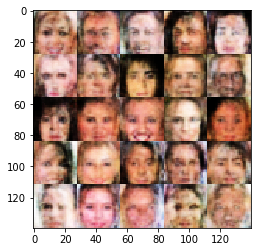

Epoch 3/6... Discriminator Loss: 1.3122... Generator Loss: 0.7181
Epoch 3/6... Discriminator Loss: 1.2553... Generator Loss: 0.8093
Epoch 3/6... Discriminator Loss: 1.2325... Generator Loss: 0.9475
Epoch 3/6... Discriminator Loss: 1.1732... Generator Loss: 2.1007
Epoch 3/6... Discriminator Loss: 1.1983... Generator Loss: 1.7579
Epoch 3/6... Discriminator Loss: 1.1255... Generator Loss: 1.0790
Epoch 3/6... Discriminator Loss: 1.1256... Generator Loss: 1.5903
Epoch 3/6... Discriminator Loss: 1.1282... Generator Loss: 1.4981
Epoch 3/6... Discriminator Loss: 1.0865... Generator Loss: 1.1305
Epoch 3/6... Discriminator Loss: 1.1203... Generator Loss: 0.9114
Epoch 3/6... Discriminator Loss: 1.1599... Generator Loss: 1.0262
Epoch 3/6... Discriminator Loss: 1.0939... Generator Loss: 1.1098
Epoch 3/6... Discriminator Loss: 1.0911... Generator Loss: 1.0912
Epoch 3/6... Discriminator Loss: 1.0599... Generator Loss: 1.0857
Epoch 3/6... Discriminator Loss: 1.1518... Generator Loss: 0.9663
Epoch 3/6.

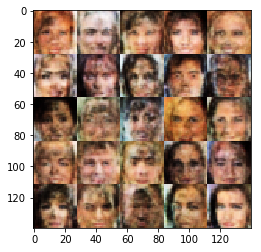

Epoch 3/6... Discriminator Loss: 1.1475... Generator Loss: 1.0879
Epoch 3/6... Discriminator Loss: 1.1276... Generator Loss: 1.1432
Epoch 3/6... Discriminator Loss: 1.0043... Generator Loss: 1.1238
Epoch 3/6... Discriminator Loss: 1.1319... Generator Loss: 0.9535
Epoch 3/6... Discriminator Loss: 0.8444... Generator Loss: 1.4233
Epoch 3/6... Discriminator Loss: 1.1825... Generator Loss: 1.4190
Epoch 3/6... Discriminator Loss: 1.1539... Generator Loss: 0.9730
Epoch 3/6... Discriminator Loss: 1.1887... Generator Loss: 0.9602
Epoch 3/6... Discriminator Loss: 1.1515... Generator Loss: 1.1496
Epoch 3/6... Discriminator Loss: 1.2212... Generator Loss: 1.2930
Epoch 3/6... Discriminator Loss: 1.1255... Generator Loss: 1.0979
Epoch 3/6... Discriminator Loss: 0.9964... Generator Loss: 1.0297
Epoch 3/6... Discriminator Loss: 1.2543... Generator Loss: 0.6640
Epoch 3/6... Discriminator Loss: 1.2272... Generator Loss: 0.8112
Epoch 3/6... Discriminator Loss: 1.1484... Generator Loss: 0.8787
Epoch 3/6.

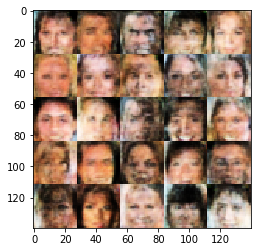

Epoch 3/6... Discriminator Loss: 1.1546... Generator Loss: 1.6650
Epoch 3/6... Discriminator Loss: 1.1983... Generator Loss: 1.0006
Epoch 3/6... Discriminator Loss: 1.1116... Generator Loss: 1.1814
Epoch 3/6... Discriminator Loss: 1.1182... Generator Loss: 1.1588
Epoch 3/6... Discriminator Loss: 1.1638... Generator Loss: 1.1000
Epoch 3/6... Discriminator Loss: 1.1041... Generator Loss: 1.1260
Epoch 3/6... Discriminator Loss: 1.1971... Generator Loss: 0.8019
Epoch 3/6... Discriminator Loss: 1.1605... Generator Loss: 1.3425
Epoch 3/6... Discriminator Loss: 1.1743... Generator Loss: 1.0643
Epoch 3/6... Discriminator Loss: 1.1940... Generator Loss: 0.8589
Epoch 3/6... Discriminator Loss: 1.1450... Generator Loss: 0.9299
Epoch 3/6... Discriminator Loss: 1.1710... Generator Loss: 0.9236
Epoch 3/6... Discriminator Loss: 1.1358... Generator Loss: 1.2038
Epoch 3/6... Discriminator Loss: 0.9124... Generator Loss: 1.2205
Epoch 3/6... Discriminator Loss: 1.2014... Generator Loss: 0.8643
Epoch 3/6.

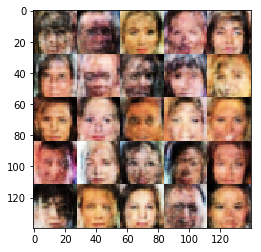

Epoch 3/6... Discriminator Loss: 1.2749... Generator Loss: 0.7576
Epoch 3/6... Discriminator Loss: 1.1778... Generator Loss: 0.8039
Epoch 3/6... Discriminator Loss: 1.1507... Generator Loss: 0.9535
Epoch 3/6... Discriminator Loss: 1.2067... Generator Loss: 0.7681
Epoch 3/6... Discriminator Loss: 1.1916... Generator Loss: 0.8334
Epoch 3/6... Discriminator Loss: 1.1070... Generator Loss: 1.4811
Epoch 3/6... Discriminator Loss: 1.1799... Generator Loss: 0.8515
Epoch 3/6... Discriminator Loss: 1.1985... Generator Loss: 0.8285
Epoch 3/6... Discriminator Loss: 1.2009... Generator Loss: 0.7491
Epoch 3/6... Discriminator Loss: 1.2111... Generator Loss: 0.8230
Epoch 3/6... Discriminator Loss: 1.2454... Generator Loss: 0.7764
Epoch 3/6... Discriminator Loss: 1.1313... Generator Loss: 1.2665
Epoch 3/6... Discriminator Loss: 0.8855... Generator Loss: 1.3598
Epoch 3/6... Discriminator Loss: 1.1615... Generator Loss: 1.1142
Epoch 3/6... Discriminator Loss: 1.3090... Generator Loss: 0.7307
Epoch 3/6.

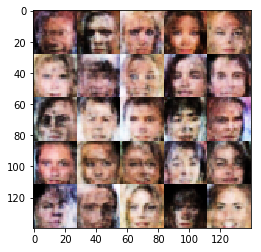

Epoch 3/6... Discriminator Loss: 0.9986... Generator Loss: 1.0375
Epoch 3/6... Discriminator Loss: 1.0850... Generator Loss: 0.8666
Epoch 3/6... Discriminator Loss: 1.1423... Generator Loss: 1.2348
Epoch 3/6... Discriminator Loss: 1.0250... Generator Loss: 1.0877
Epoch 3/6... Discriminator Loss: 1.1488... Generator Loss: 0.9711
Epoch 3/6... Discriminator Loss: 0.9961... Generator Loss: 1.3451
Epoch 3/6... Discriminator Loss: 1.1750... Generator Loss: 1.0852
Epoch 3/6... Discriminator Loss: 1.1824... Generator Loss: 0.8503
Epoch 3/6... Discriminator Loss: 1.1587... Generator Loss: 0.9609
Epoch 3/6... Discriminator Loss: 1.1266... Generator Loss: 0.9155
Epoch 3/6... Discriminator Loss: 1.2034... Generator Loss: 0.8707
Epoch 3/6... Discriminator Loss: 1.1330... Generator Loss: 0.9142
Epoch 3/6... Discriminator Loss: 1.1770... Generator Loss: 0.8084
Epoch 3/6... Discriminator Loss: 1.1353... Generator Loss: 0.9229
Epoch 3/6... Discriminator Loss: 1.1459... Generator Loss: 0.9383
Epoch 3/6.

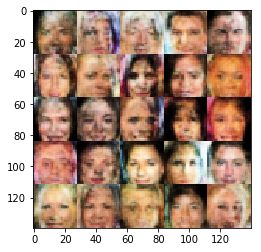

Epoch 3/6... Discriminator Loss: 1.2267... Generator Loss: 0.7791
Epoch 3/6... Discriminator Loss: 1.1142... Generator Loss: 0.8292
Epoch 3/6... Discriminator Loss: 1.1175... Generator Loss: 1.2019
Epoch 3/6... Discriminator Loss: 1.2025... Generator Loss: 0.7641
Epoch 3/6... Discriminator Loss: 1.0450... Generator Loss: 1.2536
Epoch 3/6... Discriminator Loss: 1.1103... Generator Loss: 1.0955
Epoch 3/6... Discriminator Loss: 1.3079... Generator Loss: 1.0412
Epoch 3/6... Discriminator Loss: 1.3859... Generator Loss: 0.6308
Epoch 3/6... Discriminator Loss: 1.3284... Generator Loss: 1.8572
Epoch 4/6... Discriminator Loss: 1.1540... Generator Loss: 1.3753
Epoch 4/6... Discriminator Loss: 1.2478... Generator Loss: 1.1787
Epoch 4/6... Discriminator Loss: 1.2099... Generator Loss: 1.0092
Epoch 4/6... Discriminator Loss: 1.2784... Generator Loss: 0.9996
Epoch 4/6... Discriminator Loss: 1.1126... Generator Loss: 1.1665
Epoch 4/6... Discriminator Loss: 1.3533... Generator Loss: 0.6092
Epoch 4/6.

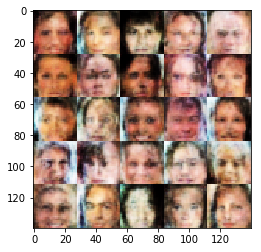

Epoch 4/6... Discriminator Loss: 1.1608... Generator Loss: 0.9655
Epoch 4/6... Discriminator Loss: 1.1729... Generator Loss: 1.1248
Epoch 4/6... Discriminator Loss: 1.3469... Generator Loss: 0.7438
Epoch 4/6... Discriminator Loss: 1.2371... Generator Loss: 0.7178
Epoch 4/6... Discriminator Loss: 1.3524... Generator Loss: 0.7112
Epoch 4/6... Discriminator Loss: 1.4172... Generator Loss: 0.9704
Epoch 4/6... Discriminator Loss: 1.2330... Generator Loss: 0.7917
Epoch 4/6... Discriminator Loss: 1.2336... Generator Loss: 0.7867
Epoch 4/6... Discriminator Loss: 1.0954... Generator Loss: 1.0159
Epoch 4/6... Discriminator Loss: 1.1068... Generator Loss: 0.9358
Epoch 4/6... Discriminator Loss: 1.1107... Generator Loss: 1.2435
Epoch 4/6... Discriminator Loss: 1.1878... Generator Loss: 1.0304
Epoch 4/6... Discriminator Loss: 1.1725... Generator Loss: 1.0989
Epoch 4/6... Discriminator Loss: 1.0957... Generator Loss: 1.4822
Epoch 4/6... Discriminator Loss: 1.2805... Generator Loss: 0.7771
Epoch 4/6.

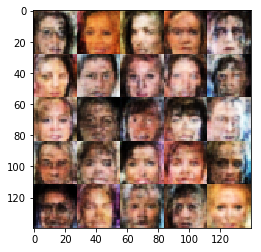

Epoch 4/6... Discriminator Loss: 1.2461... Generator Loss: 0.7825
Epoch 4/6... Discriminator Loss: 1.1955... Generator Loss: 0.7819
Epoch 4/6... Discriminator Loss: 1.2886... Generator Loss: 0.6941
Epoch 4/6... Discriminator Loss: 1.2559... Generator Loss: 0.8654
Epoch 4/6... Discriminator Loss: 1.0795... Generator Loss: 1.4222
Epoch 4/6... Discriminator Loss: 1.1870... Generator Loss: 1.0782
Epoch 4/6... Discriminator Loss: 1.1315... Generator Loss: 0.9283
Epoch 4/6... Discriminator Loss: 1.2404... Generator Loss: 0.9160
Epoch 4/6... Discriminator Loss: 1.2108... Generator Loss: 1.0032
Epoch 4/6... Discriminator Loss: 1.2659... Generator Loss: 1.5060
Epoch 4/6... Discriminator Loss: 1.1689... Generator Loss: 0.9716
Epoch 4/6... Discriminator Loss: 1.1962... Generator Loss: 0.9017
Epoch 4/6... Discriminator Loss: 1.1365... Generator Loss: 0.9685
Epoch 4/6... Discriminator Loss: 1.1778... Generator Loss: 0.8942
Epoch 4/6... Discriminator Loss: 1.1769... Generator Loss: 1.6701
Epoch 4/6.

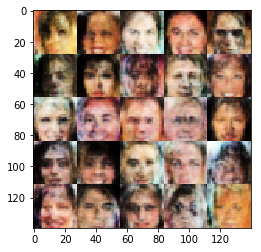

Epoch 4/6... Discriminator Loss: 1.1755... Generator Loss: 1.0680
Epoch 4/6... Discriminator Loss: 1.2374... Generator Loss: 0.9010
Epoch 4/6... Discriminator Loss: 1.1294... Generator Loss: 0.9936
Epoch 4/6... Discriminator Loss: 1.2156... Generator Loss: 0.7981
Epoch 4/6... Discriminator Loss: 1.2425... Generator Loss: 0.9583
Epoch 4/6... Discriminator Loss: 1.0496... Generator Loss: 1.1171
Epoch 4/6... Discriminator Loss: 1.1111... Generator Loss: 0.9634
Epoch 4/6... Discriminator Loss: 1.2056... Generator Loss: 1.3660
Epoch 4/6... Discriminator Loss: 1.2125... Generator Loss: 1.2244
Epoch 4/6... Discriminator Loss: 1.1523... Generator Loss: 1.2960
Epoch 4/6... Discriminator Loss: 1.1385... Generator Loss: 1.1484
Epoch 4/6... Discriminator Loss: 1.1324... Generator Loss: 1.0351
Epoch 4/6... Discriminator Loss: 1.0603... Generator Loss: 1.2304
Epoch 4/6... Discriminator Loss: 1.1838... Generator Loss: 1.0489
Epoch 4/6... Discriminator Loss: 1.1971... Generator Loss: 0.9243
Epoch 4/6.

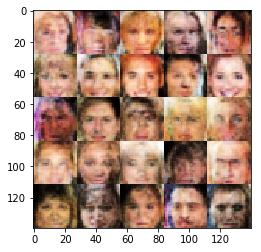

Epoch 4/6... Discriminator Loss: 1.2112... Generator Loss: 0.8228
Epoch 4/6... Discriminator Loss: 1.2250... Generator Loss: 0.8904
Epoch 4/6... Discriminator Loss: 1.1140... Generator Loss: 0.9832
Epoch 4/6... Discriminator Loss: 1.1734... Generator Loss: 0.9418
Epoch 4/6... Discriminator Loss: 1.1615... Generator Loss: 1.0067
Epoch 4/6... Discriminator Loss: 1.3200... Generator Loss: 0.7648
Epoch 4/6... Discriminator Loss: 1.1911... Generator Loss: 0.9700
Epoch 4/6... Discriminator Loss: 1.1983... Generator Loss: 1.2813
Epoch 4/6... Discriminator Loss: 1.1682... Generator Loss: 1.1024
Epoch 4/6... Discriminator Loss: 1.1416... Generator Loss: 1.0527
Epoch 4/6... Discriminator Loss: 1.1953... Generator Loss: 1.2550
Epoch 4/6... Discriminator Loss: 1.3111... Generator Loss: 0.7590
Epoch 4/6... Discriminator Loss: 0.9783... Generator Loss: 1.3462
Epoch 4/6... Discriminator Loss: 1.3467... Generator Loss: 0.7167
Epoch 4/6... Discriminator Loss: 1.1134... Generator Loss: 1.1511
Epoch 4/6.

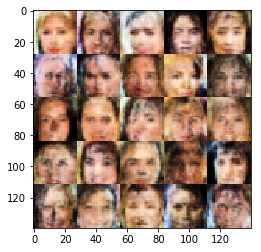

Epoch 4/6... Discriminator Loss: 1.2344... Generator Loss: 1.1920
Epoch 4/6... Discriminator Loss: 1.1662... Generator Loss: 1.0386
Epoch 4/6... Discriminator Loss: 1.1659... Generator Loss: 0.8221
Epoch 4/6... Discriminator Loss: 1.1790... Generator Loss: 0.9890
Epoch 4/6... Discriminator Loss: 1.1385... Generator Loss: 0.9586
Epoch 4/6... Discriminator Loss: 1.1550... Generator Loss: 1.3004
Epoch 4/6... Discriminator Loss: 1.1236... Generator Loss: 1.2016
Epoch 4/6... Discriminator Loss: 1.1400... Generator Loss: 1.1062
Epoch 4/6... Discriminator Loss: 1.1253... Generator Loss: 0.9150
Epoch 4/6... Discriminator Loss: 1.1580... Generator Loss: 1.0992
Epoch 4/6... Discriminator Loss: 1.1220... Generator Loss: 1.4260
Epoch 4/6... Discriminator Loss: 1.2567... Generator Loss: 1.1078
Epoch 4/6... Discriminator Loss: 1.2673... Generator Loss: 0.7654
Epoch 4/6... Discriminator Loss: 1.1798... Generator Loss: 0.9488
Epoch 4/6... Discriminator Loss: 1.1995... Generator Loss: 0.9146
Epoch 4/6.

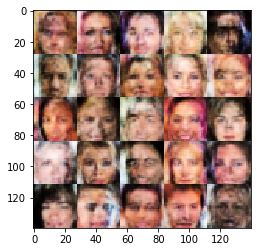

Epoch 4/6... Discriminator Loss: 1.1564... Generator Loss: 1.2244
Epoch 4/6... Discriminator Loss: 1.2096... Generator Loss: 1.0355
Epoch 4/6... Discriminator Loss: 1.2532... Generator Loss: 1.0142
Epoch 4/6... Discriminator Loss: 1.1319... Generator Loss: 1.3065
Epoch 4/6... Discriminator Loss: 1.1408... Generator Loss: 1.0389
Epoch 4/6... Discriminator Loss: 1.0359... Generator Loss: 1.4483
Epoch 4/6... Discriminator Loss: 1.1971... Generator Loss: 1.3865
Epoch 4/6... Discriminator Loss: 1.2569... Generator Loss: 0.9700
Epoch 4/6... Discriminator Loss: 1.1721... Generator Loss: 1.0663
Epoch 4/6... Discriminator Loss: 1.1708... Generator Loss: 1.0373
Epoch 4/6... Discriminator Loss: 1.0725... Generator Loss: 1.0952
Epoch 4/6... Discriminator Loss: 1.2936... Generator Loss: 0.9250
Epoch 4/6... Discriminator Loss: 1.2185... Generator Loss: 0.9805
Epoch 4/6... Discriminator Loss: 1.2328... Generator Loss: 0.9358
Epoch 4/6... Discriminator Loss: 1.3707... Generator Loss: 0.8688
Epoch 4/6.

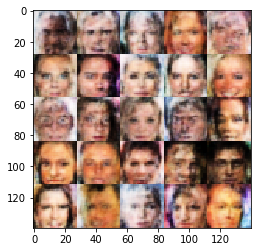

Epoch 4/6... Discriminator Loss: 1.2297... Generator Loss: 1.0751
Epoch 4/6... Discriminator Loss: 1.2701... Generator Loss: 1.1015
Epoch 4/6... Discriminator Loss: 1.2095... Generator Loss: 0.9880
Epoch 4/6... Discriminator Loss: 0.8051... Generator Loss: 1.6377
Epoch 4/6... Discriminator Loss: 1.2669... Generator Loss: 1.2078
Epoch 4/6... Discriminator Loss: 1.0363... Generator Loss: 1.1853
Epoch 4/6... Discriminator Loss: 1.1798... Generator Loss: 0.7818
Epoch 4/6... Discriminator Loss: 1.1005... Generator Loss: 1.1343
Epoch 4/6... Discriminator Loss: 1.2344... Generator Loss: 0.9841
Epoch 4/6... Discriminator Loss: 1.2191... Generator Loss: 1.0520
Epoch 4/6... Discriminator Loss: 1.2522... Generator Loss: 1.2465
Epoch 4/6... Discriminator Loss: 1.1146... Generator Loss: 1.1329
Epoch 4/6... Discriminator Loss: 1.1829... Generator Loss: 0.9438
Epoch 4/6... Discriminator Loss: 1.1716... Generator Loss: 0.8925
Epoch 4/6... Discriminator Loss: 1.1465... Generator Loss: 0.9223
Epoch 4/6.

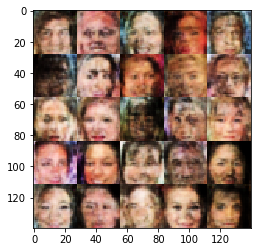

Epoch 4/6... Discriminator Loss: 1.3067... Generator Loss: 0.7890
Epoch 4/6... Discriminator Loss: 1.2515... Generator Loss: 0.9257
Epoch 4/6... Discriminator Loss: 1.1303... Generator Loss: 1.2080
Epoch 4/6... Discriminator Loss: 1.2149... Generator Loss: 0.8636
Epoch 4/6... Discriminator Loss: 1.1441... Generator Loss: 1.0779
Epoch 4/6... Discriminator Loss: 1.2257... Generator Loss: 0.9533
Epoch 4/6... Discriminator Loss: 1.1525... Generator Loss: 1.3223
Epoch 4/6... Discriminator Loss: 1.1971... Generator Loss: 1.0675
Epoch 4/6... Discriminator Loss: 1.3018... Generator Loss: 0.7665
Epoch 4/6... Discriminator Loss: 1.2204... Generator Loss: 0.8764
Epoch 4/6... Discriminator Loss: 1.3642... Generator Loss: 0.8548
Epoch 4/6... Discriminator Loss: 1.3056... Generator Loss: 0.7135
Epoch 4/6... Discriminator Loss: 0.8734... Generator Loss: 1.4750
Epoch 4/6... Discriminator Loss: 1.1067... Generator Loss: 1.2607
Epoch 4/6... Discriminator Loss: 1.1317... Generator Loss: 0.8605
Epoch 4/6.

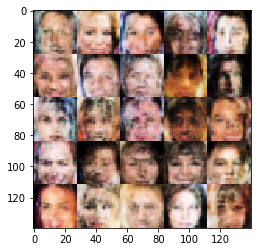

Epoch 4/6... Discriminator Loss: 1.4017... Generator Loss: 1.6202
Epoch 4/6... Discriminator Loss: 1.1971... Generator Loss: 1.0959
Epoch 4/6... Discriminator Loss: 1.1966... Generator Loss: 1.0943
Epoch 4/6... Discriminator Loss: 1.2656... Generator Loss: 0.9363
Epoch 4/6... Discriminator Loss: 1.1243... Generator Loss: 1.1095
Epoch 4/6... Discriminator Loss: 1.1352... Generator Loss: 0.9683
Epoch 4/6... Discriminator Loss: 1.2020... Generator Loss: 0.7766
Epoch 4/6... Discriminator Loss: 1.1787... Generator Loss: 0.9206
Epoch 4/6... Discriminator Loss: 1.2626... Generator Loss: 0.9517
Epoch 4/6... Discriminator Loss: 1.1950... Generator Loss: 1.0233
Epoch 4/6... Discriminator Loss: 1.2115... Generator Loss: 0.8898
Epoch 4/6... Discriminator Loss: 1.1168... Generator Loss: 0.9203
Epoch 4/6... Discriminator Loss: 1.2758... Generator Loss: 1.0596
Epoch 4/6... Discriminator Loss: 1.1621... Generator Loss: 0.9623
Epoch 4/6... Discriminator Loss: 1.2073... Generator Loss: 0.9782
Epoch 4/6.

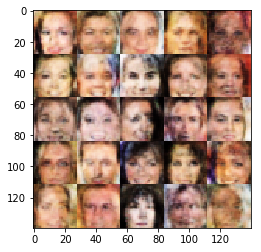

Epoch 4/6... Discriminator Loss: 1.2254... Generator Loss: 0.7917
Epoch 4/6... Discriminator Loss: 1.3507... Generator Loss: 0.6391
Epoch 4/6... Discriminator Loss: 1.1977... Generator Loss: 0.9531
Epoch 4/6... Discriminator Loss: 1.2060... Generator Loss: 1.0542
Epoch 4/6... Discriminator Loss: 1.2086... Generator Loss: 1.0901
Epoch 4/6... Discriminator Loss: 1.0944... Generator Loss: 1.1217
Epoch 4/6... Discriminator Loss: 1.1055... Generator Loss: 1.0832
Epoch 4/6... Discriminator Loss: 1.2068... Generator Loss: 0.9137
Epoch 4/6... Discriminator Loss: 1.1369... Generator Loss: 1.1258
Epoch 4/6... Discriminator Loss: 1.2101... Generator Loss: 1.1141
Epoch 4/6... Discriminator Loss: 1.2636... Generator Loss: 1.0171
Epoch 4/6... Discriminator Loss: 1.2421... Generator Loss: 1.0112
Epoch 4/6... Discriminator Loss: 1.3697... Generator Loss: 0.6181
Epoch 4/6... Discriminator Loss: 1.1643... Generator Loss: 1.0110
Epoch 4/6... Discriminator Loss: 1.2097... Generator Loss: 0.8756
Epoch 4/6.

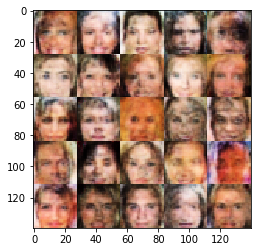

Epoch 4/6... Discriminator Loss: 1.3218... Generator Loss: 1.3626
Epoch 4/6... Discriminator Loss: 1.2539... Generator Loss: 0.9190
Epoch 4/6... Discriminator Loss: 1.2342... Generator Loss: 0.8553
Epoch 4/6... Discriminator Loss: 1.1497... Generator Loss: 0.8246
Epoch 4/6... Discriminator Loss: 1.2130... Generator Loss: 1.0472
Epoch 4/6... Discriminator Loss: 1.2893... Generator Loss: 0.8715
Epoch 4/6... Discriminator Loss: 1.0764... Generator Loss: 1.0231
Epoch 4/6... Discriminator Loss: 1.2291... Generator Loss: 1.0018
Epoch 4/6... Discriminator Loss: 1.2152... Generator Loss: 1.0564
Epoch 4/6... Discriminator Loss: 1.2190... Generator Loss: 0.8926
Epoch 4/6... Discriminator Loss: 1.2067... Generator Loss: 1.2172
Epoch 4/6... Discriminator Loss: 1.3489... Generator Loss: 0.7107
Epoch 4/6... Discriminator Loss: 1.1760... Generator Loss: 1.2150
Epoch 4/6... Discriminator Loss: 1.2022... Generator Loss: 0.9799
Epoch 4/6... Discriminator Loss: 1.2721... Generator Loss: 0.6963
Epoch 4/6.

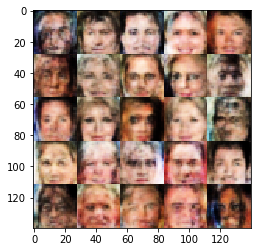

Epoch 4/6... Discriminator Loss: 1.1491... Generator Loss: 0.9085
Epoch 4/6... Discriminator Loss: 1.3043... Generator Loss: 0.9085
Epoch 4/6... Discriminator Loss: 1.3894... Generator Loss: 0.9914
Epoch 4/6... Discriminator Loss: 1.3036... Generator Loss: 0.6485
Epoch 4/6... Discriminator Loss: 1.2595... Generator Loss: 0.8880
Epoch 4/6... Discriminator Loss: 1.2478... Generator Loss: 0.9330
Epoch 4/6... Discriminator Loss: 1.1293... Generator Loss: 1.0439
Epoch 4/6... Discriminator Loss: 1.4000... Generator Loss: 0.6324
Epoch 4/6... Discriminator Loss: 1.2825... Generator Loss: 0.7115
Epoch 4/6... Discriminator Loss: 1.2312... Generator Loss: 0.9222
Epoch 4/6... Discriminator Loss: 1.2737... Generator Loss: 1.0895
Epoch 4/6... Discriminator Loss: 1.0287... Generator Loss: 1.2857
Epoch 4/6... Discriminator Loss: 1.1971... Generator Loss: 1.0623
Epoch 4/6... Discriminator Loss: 1.2996... Generator Loss: 0.7825
Epoch 4/6... Discriminator Loss: 1.5651... Generator Loss: 1.6975
Epoch 4/6.

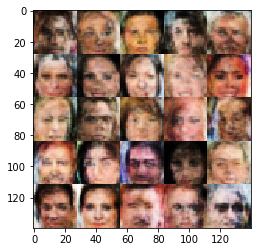

Epoch 4/6... Discriminator Loss: 1.3901... Generator Loss: 0.7734
Epoch 4/6... Discriminator Loss: 1.0694... Generator Loss: 1.2725
Epoch 4/6... Discriminator Loss: 1.2694... Generator Loss: 0.9652
Epoch 4/6... Discriminator Loss: 1.2837... Generator Loss: 0.7981
Epoch 4/6... Discriminator Loss: 1.2131... Generator Loss: 1.1942
Epoch 4/6... Discriminator Loss: 1.1857... Generator Loss: 1.2406
Epoch 4/6... Discriminator Loss: 1.2304... Generator Loss: 0.8699
Epoch 4/6... Discriminator Loss: 1.2733... Generator Loss: 0.8099
Epoch 4/6... Discriminator Loss: 1.3029... Generator Loss: 0.8502
Epoch 4/6... Discriminator Loss: 1.1779... Generator Loss: 1.0328
Epoch 4/6... Discriminator Loss: 1.2833... Generator Loss: 0.9485
Epoch 4/6... Discriminator Loss: 1.2888... Generator Loss: 0.7238
Epoch 4/6... Discriminator Loss: 1.2064... Generator Loss: 1.0760
Epoch 4/6... Discriminator Loss: 1.2450... Generator Loss: 0.8268
Epoch 4/6... Discriminator Loss: 1.1613... Generator Loss: 1.0634
Epoch 4/6.

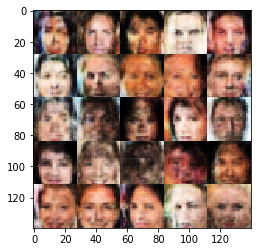

Epoch 4/6... Discriminator Loss: 1.1689... Generator Loss: 0.8823
Epoch 4/6... Discriminator Loss: 1.2444... Generator Loss: 0.8729
Epoch 4/6... Discriminator Loss: 1.2781... Generator Loss: 0.8875
Epoch 4/6... Discriminator Loss: 1.1353... Generator Loss: 0.8956
Epoch 4/6... Discriminator Loss: 1.2691... Generator Loss: 1.2211
Epoch 4/6... Discriminator Loss: 1.2631... Generator Loss: 0.9881
Epoch 4/6... Discriminator Loss: 1.1551... Generator Loss: 1.0566
Epoch 4/6... Discriminator Loss: 1.2311... Generator Loss: 1.1302
Epoch 4/6... Discriminator Loss: 1.1560... Generator Loss: 0.9631
Epoch 4/6... Discriminator Loss: 1.2097... Generator Loss: 0.9920
Epoch 4/6... Discriminator Loss: 1.3041... Generator Loss: 0.8314
Epoch 4/6... Discriminator Loss: 1.1529... Generator Loss: 1.0535
Epoch 4/6... Discriminator Loss: 1.2822... Generator Loss: 0.9766
Epoch 4/6... Discriminator Loss: 1.2058... Generator Loss: 1.0900
Epoch 4/6... Discriminator Loss: 1.1677... Generator Loss: 1.1368
Epoch 4/6.

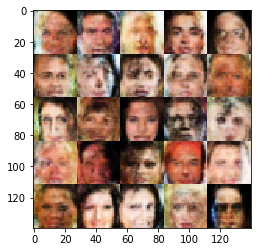

Epoch 4/6... Discriminator Loss: 1.1442... Generator Loss: 1.2392
Epoch 4/6... Discriminator Loss: 1.1776... Generator Loss: 1.0070
Epoch 4/6... Discriminator Loss: 1.3618... Generator Loss: 0.7659
Epoch 4/6... Discriminator Loss: 1.1783... Generator Loss: 0.9578
Epoch 4/6... Discriminator Loss: 1.1890... Generator Loss: 0.9212
Epoch 4/6... Discriminator Loss: 1.2726... Generator Loss: 0.9930
Epoch 4/6... Discriminator Loss: 1.1878... Generator Loss: 1.1037
Epoch 4/6... Discriminator Loss: 1.2622... Generator Loss: 0.9403
Epoch 4/6... Discriminator Loss: 1.2134... Generator Loss: 0.8448
Epoch 4/6... Discriminator Loss: 1.2102... Generator Loss: 1.0322
Epoch 4/6... Discriminator Loss: 1.2078... Generator Loss: 0.9547
Epoch 4/6... Discriminator Loss: 1.1553... Generator Loss: 1.2588
Epoch 4/6... Discriminator Loss: 1.1515... Generator Loss: 1.1863
Epoch 4/6... Discriminator Loss: 1.2044... Generator Loss: 1.0419
Epoch 4/6... Discriminator Loss: 1.2793... Generator Loss: 0.7967
Epoch 4/6.

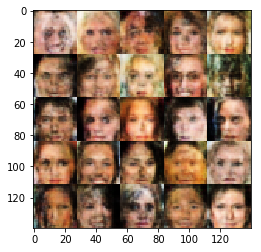

Epoch 4/6... Discriminator Loss: 1.2539... Generator Loss: 0.9610
Epoch 4/6... Discriminator Loss: 1.2628... Generator Loss: 1.0265
Epoch 4/6... Discriminator Loss: 1.2822... Generator Loss: 0.8233
Epoch 4/6... Discriminator Loss: 1.1987... Generator Loss: 0.8265
Epoch 4/6... Discriminator Loss: 1.1758... Generator Loss: 0.9204
Epoch 5/6... Discriminator Loss: 1.2687... Generator Loss: 0.7848
Epoch 5/6... Discriminator Loss: 1.2665... Generator Loss: 0.9278
Epoch 5/6... Discriminator Loss: 1.1860... Generator Loss: 0.7667
Epoch 5/6... Discriminator Loss: 1.1855... Generator Loss: 0.9774
Epoch 5/6... Discriminator Loss: 1.4738... Generator Loss: 0.5137
Epoch 5/6... Discriminator Loss: 1.2600... Generator Loss: 0.7428
Epoch 5/6... Discriminator Loss: 1.2648... Generator Loss: 0.8263
Epoch 5/6... Discriminator Loss: 1.1549... Generator Loss: 1.1667
Epoch 5/6... Discriminator Loss: 1.2978... Generator Loss: 0.8343
Epoch 5/6... Discriminator Loss: 1.3141... Generator Loss: 0.7179
Epoch 5/6.

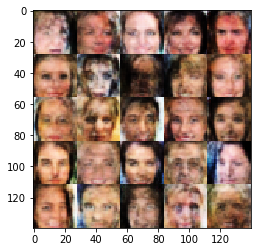

Epoch 5/6... Discriminator Loss: 1.2954... Generator Loss: 0.7283
Epoch 5/6... Discriminator Loss: 1.1036... Generator Loss: 1.1124
Epoch 5/6... Discriminator Loss: 1.3076... Generator Loss: 0.8140
Epoch 5/6... Discriminator Loss: 1.2307... Generator Loss: 0.9462
Epoch 5/6... Discriminator Loss: 1.2078... Generator Loss: 0.9981
Epoch 5/6... Discriminator Loss: 1.1405... Generator Loss: 1.1473
Epoch 5/6... Discriminator Loss: 1.2383... Generator Loss: 0.8676
Epoch 5/6... Discriminator Loss: 1.3436... Generator Loss: 0.6623
Epoch 5/6... Discriminator Loss: 1.2504... Generator Loss: 1.3573
Epoch 5/6... Discriminator Loss: 1.2474... Generator Loss: 1.1092
Epoch 5/6... Discriminator Loss: 1.2101... Generator Loss: 1.0363
Epoch 5/6... Discriminator Loss: 1.1965... Generator Loss: 1.0239
Epoch 5/6... Discriminator Loss: 1.3088... Generator Loss: 1.1856
Epoch 5/6... Discriminator Loss: 1.1030... Generator Loss: 1.2455
Epoch 5/6... Discriminator Loss: 1.1719... Generator Loss: 1.0044
Epoch 5/6.

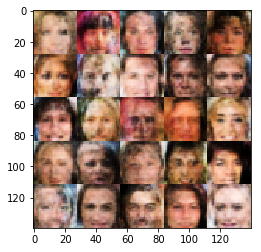

Epoch 5/6... Discriminator Loss: 1.2069... Generator Loss: 0.7551
Epoch 5/6... Discriminator Loss: 1.2329... Generator Loss: 0.8586
Epoch 5/6... Discriminator Loss: 1.2777... Generator Loss: 0.8120
Epoch 5/6... Discriminator Loss: 1.2567... Generator Loss: 0.8379
Epoch 5/6... Discriminator Loss: 1.2462... Generator Loss: 0.7502
Epoch 5/6... Discriminator Loss: 1.2603... Generator Loss: 0.9285
Epoch 5/6... Discriminator Loss: 0.9987... Generator Loss: 1.3900
Epoch 5/6... Discriminator Loss: 1.2527... Generator Loss: 1.0441
Epoch 5/6... Discriminator Loss: 1.1073... Generator Loss: 1.3233
Epoch 5/6... Discriminator Loss: 1.1215... Generator Loss: 1.0876
Epoch 5/6... Discriminator Loss: 1.2441... Generator Loss: 0.7230
Epoch 5/6... Discriminator Loss: 1.3211... Generator Loss: 0.7685
Epoch 5/6... Discriminator Loss: 1.1452... Generator Loss: 1.1456
Epoch 5/6... Discriminator Loss: 1.2858... Generator Loss: 0.9756
Epoch 5/6... Discriminator Loss: 1.1440... Generator Loss: 1.0532
Epoch 5/6.

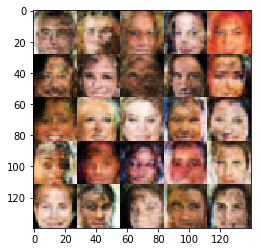

Epoch 5/6... Discriminator Loss: 1.3102... Generator Loss: 0.6141
Epoch 5/6... Discriminator Loss: 1.2237... Generator Loss: 0.8382
Epoch 5/6... Discriminator Loss: 1.2944... Generator Loss: 0.7259
Epoch 5/6... Discriminator Loss: 1.1438... Generator Loss: 1.0084
Epoch 5/6... Discriminator Loss: 1.2295... Generator Loss: 0.8774
Epoch 5/6... Discriminator Loss: 1.2443... Generator Loss: 1.1344
Epoch 5/6... Discriminator Loss: 1.1999... Generator Loss: 0.9252
Epoch 5/6... Discriminator Loss: 1.1647... Generator Loss: 1.0387
Epoch 5/6... Discriminator Loss: 1.1822... Generator Loss: 1.0847
Epoch 5/6... Discriminator Loss: 1.2192... Generator Loss: 0.9605
Epoch 5/6... Discriminator Loss: 1.2780... Generator Loss: 1.0032
Epoch 5/6... Discriminator Loss: 1.2157... Generator Loss: 1.1205
Epoch 5/6... Discriminator Loss: 1.3045... Generator Loss: 0.8059
Epoch 5/6... Discriminator Loss: 1.2321... Generator Loss: 1.0159
Epoch 5/6... Discriminator Loss: 1.2070... Generator Loss: 1.1675
Epoch 5/6.

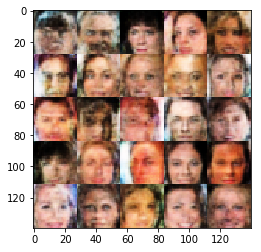

Epoch 5/6... Discriminator Loss: 1.1779... Generator Loss: 1.1574
Epoch 5/6... Discriminator Loss: 1.3168... Generator Loss: 0.7098
Epoch 5/6... Discriminator Loss: 1.2744... Generator Loss: 0.9723
Epoch 5/6... Discriminator Loss: 1.1460... Generator Loss: 1.1177
Epoch 5/6... Discriminator Loss: 1.1519... Generator Loss: 0.9910
Epoch 5/6... Discriminator Loss: 1.2400... Generator Loss: 0.7595
Epoch 5/6... Discriminator Loss: 1.3361... Generator Loss: 0.6845
Epoch 5/6... Discriminator Loss: 1.2611... Generator Loss: 0.7965
Epoch 5/6... Discriminator Loss: 1.2797... Generator Loss: 0.8194
Epoch 5/6... Discriminator Loss: 1.2236... Generator Loss: 0.9050
Epoch 5/6... Discriminator Loss: 1.0848... Generator Loss: 0.9998
Epoch 5/6... Discriminator Loss: 1.3556... Generator Loss: 0.8119
Epoch 5/6... Discriminator Loss: 1.3413... Generator Loss: 0.7029
Epoch 5/6... Discriminator Loss: 1.2570... Generator Loss: 0.9457
Epoch 5/6... Discriminator Loss: 1.2184... Generator Loss: 0.8917
Epoch 5/6.

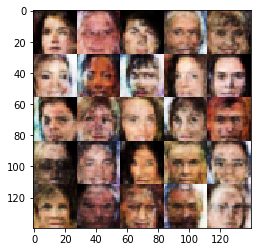

Epoch 5/6... Discriminator Loss: 1.2124... Generator Loss: 0.7932
Epoch 5/6... Discriminator Loss: 1.3987... Generator Loss: 0.6140
Epoch 5/6... Discriminator Loss: 1.3777... Generator Loss: 0.6299
Epoch 5/6... Discriminator Loss: 1.2625... Generator Loss: 0.6896
Epoch 5/6... Discriminator Loss: 1.2431... Generator Loss: 0.7663
Epoch 5/6... Discriminator Loss: 1.3267... Generator Loss: 0.7814
Epoch 5/6... Discriminator Loss: 1.1705... Generator Loss: 1.0581
Epoch 5/6... Discriminator Loss: 1.2124... Generator Loss: 0.9694
Epoch 5/6... Discriminator Loss: 1.2742... Generator Loss: 0.7407
Epoch 5/6... Discriminator Loss: 1.2613... Generator Loss: 0.9011
Epoch 5/6... Discriminator Loss: 1.2532... Generator Loss: 1.2693
Epoch 5/6... Discriminator Loss: 1.2475... Generator Loss: 0.8547
Epoch 5/6... Discriminator Loss: 1.1686... Generator Loss: 0.8386
Epoch 5/6... Discriminator Loss: 1.3962... Generator Loss: 0.6442
Epoch 5/6... Discriminator Loss: 1.2715... Generator Loss: 0.8644
Epoch 5/6.

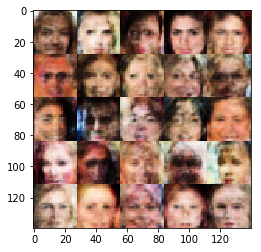

Epoch 5/6... Discriminator Loss: 1.2711... Generator Loss: 0.9846
Epoch 5/6... Discriminator Loss: 1.2759... Generator Loss: 0.8814
Epoch 5/6... Discriminator Loss: 1.1331... Generator Loss: 1.1027
Epoch 5/6... Discriminator Loss: 1.3506... Generator Loss: 0.6156
Epoch 5/6... Discriminator Loss: 1.2681... Generator Loss: 0.8468
Epoch 5/6... Discriminator Loss: 1.2534... Generator Loss: 0.9788
Epoch 5/6... Discriminator Loss: 1.1566... Generator Loss: 1.0475
Epoch 5/6... Discriminator Loss: 1.2688... Generator Loss: 0.9768
Epoch 5/6... Discriminator Loss: 1.2743... Generator Loss: 0.8045
Epoch 5/6... Discriminator Loss: 1.0181... Generator Loss: 1.6359
Epoch 5/6... Discriminator Loss: 1.3228... Generator Loss: 0.9597
Epoch 5/6... Discriminator Loss: 1.2071... Generator Loss: 0.9210
Epoch 5/6... Discriminator Loss: 1.2435... Generator Loss: 0.8042
Epoch 5/6... Discriminator Loss: 1.2268... Generator Loss: 1.0612
Epoch 5/6... Discriminator Loss: 1.2129... Generator Loss: 0.8392
Epoch 5/6.

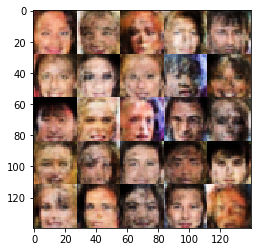

Epoch 5/6... Discriminator Loss: 1.3507... Generator Loss: 0.6132
Epoch 5/6... Discriminator Loss: 1.3269... Generator Loss: 0.7405
Epoch 5/6... Discriminator Loss: 1.2306... Generator Loss: 0.9108
Epoch 5/6... Discriminator Loss: 1.2196... Generator Loss: 0.8314
Epoch 5/6... Discriminator Loss: 1.2557... Generator Loss: 1.0478
Epoch 5/6... Discriminator Loss: 1.2799... Generator Loss: 0.8285
Epoch 5/6... Discriminator Loss: 1.2279... Generator Loss: 0.8966
Epoch 5/6... Discriminator Loss: 1.2041... Generator Loss: 0.9006
Epoch 5/6... Discriminator Loss: 1.3577... Generator Loss: 0.6960
Epoch 5/6... Discriminator Loss: 1.2706... Generator Loss: 1.0512
Epoch 5/6... Discriminator Loss: 1.0939... Generator Loss: 1.0889
Epoch 5/6... Discriminator Loss: 1.3479... Generator Loss: 0.7801
Epoch 5/6... Discriminator Loss: 1.3366... Generator Loss: 0.8198
Epoch 5/6... Discriminator Loss: 1.3339... Generator Loss: 0.6380
Epoch 5/6... Discriminator Loss: 1.2367... Generator Loss: 0.8849
Epoch 5/6.

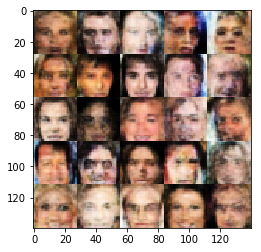

Epoch 5/6... Discriminator Loss: 1.2711... Generator Loss: 0.7678
Epoch 5/6... Discriminator Loss: 1.2988... Generator Loss: 0.8764
Epoch 5/6... Discriminator Loss: 1.2821... Generator Loss: 0.9392
Epoch 5/6... Discriminator Loss: 1.2135... Generator Loss: 0.9465
Epoch 5/6... Discriminator Loss: 1.3136... Generator Loss: 0.9953
Epoch 5/6... Discriminator Loss: 1.2568... Generator Loss: 0.8513
Epoch 5/6... Discriminator Loss: 1.2699... Generator Loss: 0.8628
Epoch 5/6... Discriminator Loss: 1.2788... Generator Loss: 0.8263
Epoch 5/6... Discriminator Loss: 1.2263... Generator Loss: 0.8316
Epoch 5/6... Discriminator Loss: 1.2600... Generator Loss: 0.8226
Epoch 5/6... Discriminator Loss: 1.2218... Generator Loss: 0.7033
Epoch 5/6... Discriminator Loss: 1.2181... Generator Loss: 0.8329
Epoch 5/6... Discriminator Loss: 1.3031... Generator Loss: 0.7005
Epoch 5/6... Discriminator Loss: 1.2482... Generator Loss: 0.8819
Epoch 5/6... Discriminator Loss: 1.3762... Generator Loss: 0.8010
Epoch 5/6.

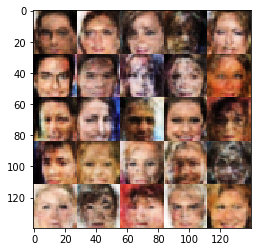

Epoch 5/6... Discriminator Loss: 1.2638... Generator Loss: 0.8670
Epoch 5/6... Discriminator Loss: 1.1924... Generator Loss: 0.9524
Epoch 5/6... Discriminator Loss: 1.2725... Generator Loss: 0.8364
Epoch 5/6... Discriminator Loss: 1.2033... Generator Loss: 1.0007
Epoch 5/6... Discriminator Loss: 1.3019... Generator Loss: 0.8081
Epoch 5/6... Discriminator Loss: 1.2371... Generator Loss: 0.7933
Epoch 5/6... Discriminator Loss: 1.2239... Generator Loss: 0.8362
Epoch 5/6... Discriminator Loss: 1.1978... Generator Loss: 0.9854
Epoch 5/6... Discriminator Loss: 1.1164... Generator Loss: 1.4263
Epoch 5/6... Discriminator Loss: 1.3384... Generator Loss: 0.8121
Epoch 5/6... Discriminator Loss: 1.3036... Generator Loss: 0.7493
Epoch 5/6... Discriminator Loss: 1.2337... Generator Loss: 0.9820
Epoch 5/6... Discriminator Loss: 1.1770... Generator Loss: 1.1090
Epoch 5/6... Discriminator Loss: 1.1445... Generator Loss: 0.9391
Epoch 5/6... Discriminator Loss: 1.3016... Generator Loss: 0.7424
Epoch 5/6.

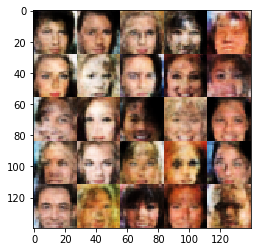

Epoch 5/6... Discriminator Loss: 1.2036... Generator Loss: 0.8209
Epoch 5/6... Discriminator Loss: 1.2402... Generator Loss: 0.9185
Epoch 5/6... Discriminator Loss: 1.2904... Generator Loss: 0.7897
Epoch 5/6... Discriminator Loss: 1.1868... Generator Loss: 0.8782
Epoch 5/6... Discriminator Loss: 1.3326... Generator Loss: 0.8816
Epoch 5/6... Discriminator Loss: 1.3192... Generator Loss: 0.9878
Epoch 5/6... Discriminator Loss: 1.1686... Generator Loss: 1.0255
Epoch 5/6... Discriminator Loss: 1.2667... Generator Loss: 0.8166
Epoch 5/6... Discriminator Loss: 1.2765... Generator Loss: 1.1239
Epoch 5/6... Discriminator Loss: 1.2269... Generator Loss: 1.2238
Epoch 5/6... Discriminator Loss: 1.4755... Generator Loss: 0.5102
Epoch 5/6... Discriminator Loss: 1.2474... Generator Loss: 1.0592
Epoch 5/6... Discriminator Loss: 1.2479... Generator Loss: 0.8155
Epoch 5/6... Discriminator Loss: 1.3220... Generator Loss: 0.7827
Epoch 5/6... Discriminator Loss: 1.2576... Generator Loss: 1.0976
Epoch 5/6.

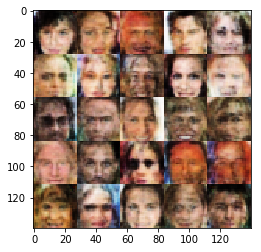

Epoch 5/6... Discriminator Loss: 1.3042... Generator Loss: 0.6649
Epoch 5/6... Discriminator Loss: 1.2452... Generator Loss: 0.6936
Epoch 5/6... Discriminator Loss: 1.2363... Generator Loss: 1.0204
Epoch 5/6... Discriminator Loss: 1.2857... Generator Loss: 0.8435
Epoch 5/6... Discriminator Loss: 1.2203... Generator Loss: 0.8780
Epoch 5/6... Discriminator Loss: 1.2313... Generator Loss: 1.0548
Epoch 5/6... Discriminator Loss: 1.2689... Generator Loss: 1.2192
Epoch 5/6... Discriminator Loss: 1.2059... Generator Loss: 0.8685
Epoch 5/6... Discriminator Loss: 1.2235... Generator Loss: 1.0569
Epoch 5/6... Discriminator Loss: 1.2766... Generator Loss: 0.8029
Epoch 5/6... Discriminator Loss: 1.3560... Generator Loss: 0.7928
Epoch 5/6... Discriminator Loss: 1.1528... Generator Loss: 0.8218
Epoch 5/6... Discriminator Loss: 1.2046... Generator Loss: 1.0403
Epoch 5/6... Discriminator Loss: 1.3035... Generator Loss: 0.8808
Epoch 5/6... Discriminator Loss: 1.2855... Generator Loss: 1.1600
Epoch 5/6.

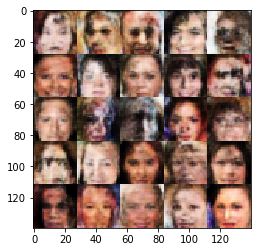

Epoch 5/6... Discriminator Loss: 1.2670... Generator Loss: 0.7498
Epoch 5/6... Discriminator Loss: 1.3298... Generator Loss: 0.7690
Epoch 5/6... Discriminator Loss: 1.1911... Generator Loss: 1.2441
Epoch 5/6... Discriminator Loss: 1.2795... Generator Loss: 1.0127
Epoch 5/6... Discriminator Loss: 1.2499... Generator Loss: 0.8520
Epoch 5/6... Discriminator Loss: 1.2787... Generator Loss: 0.9909
Epoch 5/6... Discriminator Loss: 1.2214... Generator Loss: 0.7424
Epoch 5/6... Discriminator Loss: 1.3513... Generator Loss: 0.8924
Epoch 5/6... Discriminator Loss: 1.3539... Generator Loss: 0.8376
Epoch 5/6... Discriminator Loss: 1.2500... Generator Loss: 0.9003
Epoch 5/6... Discriminator Loss: 1.2127... Generator Loss: 0.8526
Epoch 5/6... Discriminator Loss: 1.2792... Generator Loss: 0.9230
Epoch 5/6... Discriminator Loss: 1.2006... Generator Loss: 0.9752
Epoch 5/6... Discriminator Loss: 1.3278... Generator Loss: 0.8397
Epoch 5/6... Discriminator Loss: 1.3090... Generator Loss: 0.9076
Epoch 5/6.

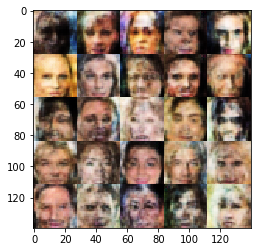

Epoch 5/6... Discriminator Loss: 1.2859... Generator Loss: 0.7201
Epoch 5/6... Discriminator Loss: 1.1436... Generator Loss: 0.9990
Epoch 5/6... Discriminator Loss: 1.2529... Generator Loss: 1.1051
Epoch 5/6... Discriminator Loss: 1.3311... Generator Loss: 1.0056
Epoch 5/6... Discriminator Loss: 1.3061... Generator Loss: 0.8244
Epoch 5/6... Discriminator Loss: 1.2664... Generator Loss: 0.7683
Epoch 5/6... Discriminator Loss: 1.2462... Generator Loss: 0.8105
Epoch 5/6... Discriminator Loss: 1.3041... Generator Loss: 0.7449
Epoch 5/6... Discriminator Loss: 1.2012... Generator Loss: 0.9810
Epoch 5/6... Discriminator Loss: 1.2469... Generator Loss: 0.9811
Epoch 5/6... Discriminator Loss: 1.2317... Generator Loss: 1.1646
Epoch 5/6... Discriminator Loss: 1.1301... Generator Loss: 1.0895
Epoch 5/6... Discriminator Loss: 1.2793... Generator Loss: 0.8612
Epoch 5/6... Discriminator Loss: 1.2243... Generator Loss: 0.8890
Epoch 5/6... Discriminator Loss: 1.2939... Generator Loss: 0.8435
Epoch 5/6.

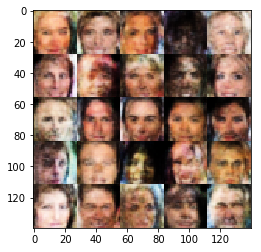

Epoch 5/6... Discriminator Loss: 1.2345... Generator Loss: 1.0023
Epoch 5/6... Discriminator Loss: 1.2618... Generator Loss: 0.9948
Epoch 5/6... Discriminator Loss: 1.2405... Generator Loss: 0.8796
Epoch 5/6... Discriminator Loss: 1.2427... Generator Loss: 1.0888
Epoch 5/6... Discriminator Loss: 1.3044... Generator Loss: 0.8169
Epoch 5/6... Discriminator Loss: 1.2818... Generator Loss: 0.8041
Epoch 5/6... Discriminator Loss: 1.2883... Generator Loss: 0.8200
Epoch 5/6... Discriminator Loss: 1.2818... Generator Loss: 0.6784
Epoch 5/6... Discriminator Loss: 1.1769... Generator Loss: 0.8761
Epoch 5/6... Discriminator Loss: 1.1200... Generator Loss: 1.1085
Epoch 5/6... Discriminator Loss: 1.3100... Generator Loss: 1.0034
Epoch 5/6... Discriminator Loss: 1.2675... Generator Loss: 0.8741
Epoch 5/6... Discriminator Loss: 1.2342... Generator Loss: 0.9628
Epoch 5/6... Discriminator Loss: 1.3146... Generator Loss: 0.7314
Epoch 5/6... Discriminator Loss: 1.2346... Generator Loss: 1.0440
Epoch 5/6.

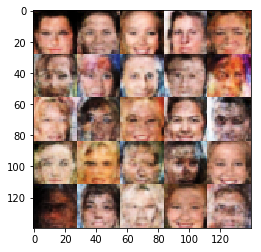

Epoch 5/6... Discriminator Loss: 1.2774... Generator Loss: 0.9927
Epoch 5/6... Discriminator Loss: 1.2433... Generator Loss: 1.0638
Epoch 5/6... Discriminator Loss: 1.3970... Generator Loss: 0.6195
Epoch 5/6... Discriminator Loss: 1.2129... Generator Loss: 0.8543
Epoch 5/6... Discriminator Loss: 1.2818... Generator Loss: 0.8226
Epoch 5/6... Discriminator Loss: 1.2826... Generator Loss: 0.8581
Epoch 5/6... Discriminator Loss: 1.2888... Generator Loss: 0.9611
Epoch 5/6... Discriminator Loss: 1.3138... Generator Loss: 0.8799
Epoch 5/6... Discriminator Loss: 1.2833... Generator Loss: 0.8516
Epoch 5/6... Discriminator Loss: 1.3074... Generator Loss: 0.8543
Epoch 5/6... Discriminator Loss: 1.3374... Generator Loss: 0.6753
Epoch 5/6... Discriminator Loss: 1.2619... Generator Loss: 0.7618
Epoch 5/6... Discriminator Loss: 1.3157... Generator Loss: 0.7744
Epoch 5/6... Discriminator Loss: 1.3301... Generator Loss: 0.7281
Epoch 5/6... Discriminator Loss: 1.2949... Generator Loss: 0.8392
Epoch 5/6.

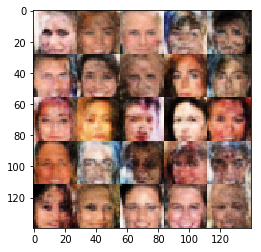

Epoch 5/6... Discriminator Loss: 1.2545... Generator Loss: 1.0208
Epoch 5/6... Discriminator Loss: 1.2784... Generator Loss: 0.8118
Epoch 6/6... Discriminator Loss: 1.3524... Generator Loss: 0.7015
Epoch 6/6... Discriminator Loss: 1.2815... Generator Loss: 0.8567
Epoch 6/6... Discriminator Loss: 1.3764... Generator Loss: 0.7167
Epoch 6/6... Discriminator Loss: 1.3405... Generator Loss: 0.7349
Epoch 6/6... Discriminator Loss: 1.4308... Generator Loss: 0.5940
Epoch 6/6... Discriminator Loss: 1.1969... Generator Loss: 1.0601
Epoch 6/6... Discriminator Loss: 1.2097... Generator Loss: 0.8470
Epoch 6/6... Discriminator Loss: 1.3430... Generator Loss: 0.7329
Epoch 6/6... Discriminator Loss: 1.3811... Generator Loss: 0.6339
Epoch 6/6... Discriminator Loss: 1.3719... Generator Loss: 0.8307
Epoch 6/6... Discriminator Loss: 1.2489... Generator Loss: 0.7733
Epoch 6/6... Discriminator Loss: 1.2601... Generator Loss: 0.9163
Epoch 6/6... Discriminator Loss: 1.2634... Generator Loss: 0.9295
Epoch 6/6.

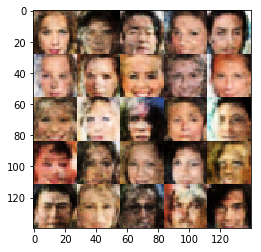

Epoch 6/6... Discriminator Loss: 1.2637... Generator Loss: 0.9091
Epoch 6/6... Discriminator Loss: 1.2681... Generator Loss: 0.9178
Epoch 6/6... Discriminator Loss: 1.2918... Generator Loss: 0.7931
Epoch 6/6... Discriminator Loss: 1.3477... Generator Loss: 0.8281
Epoch 6/6... Discriminator Loss: 1.3012... Generator Loss: 0.7897
Epoch 6/6... Discriminator Loss: 1.3086... Generator Loss: 0.7661
Epoch 6/6... Discriminator Loss: 1.3120... Generator Loss: 0.6520
Epoch 6/6... Discriminator Loss: 1.3369... Generator Loss: 0.8152
Epoch 6/6... Discriminator Loss: 1.2768... Generator Loss: 0.8535
Epoch 6/6... Discriminator Loss: 1.1465... Generator Loss: 0.9202
Epoch 6/6... Discriminator Loss: 1.3048... Generator Loss: 0.9396
Epoch 6/6... Discriminator Loss: 1.2346... Generator Loss: 0.9330
Epoch 6/6... Discriminator Loss: 1.3252... Generator Loss: 0.7807
Epoch 6/6... Discriminator Loss: 1.2121... Generator Loss: 1.0583
Epoch 6/6... Discriminator Loss: 1.2418... Generator Loss: 1.0046
Epoch 6/6.

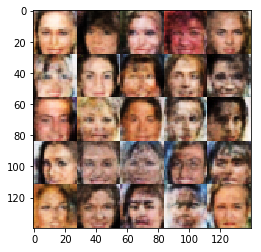

Epoch 6/6... Discriminator Loss: 1.2818... Generator Loss: 0.8390
Epoch 6/6... Discriminator Loss: 1.2831... Generator Loss: 0.9307
Epoch 6/6... Discriminator Loss: 1.2731... Generator Loss: 0.8147
Epoch 6/6... Discriminator Loss: 1.4171... Generator Loss: 0.6892
Epoch 6/6... Discriminator Loss: 1.2570... Generator Loss: 0.9397
Epoch 6/6... Discriminator Loss: 1.2347... Generator Loss: 0.9819
Epoch 6/6... Discriminator Loss: 1.2703... Generator Loss: 0.9570
Epoch 6/6... Discriminator Loss: 1.2809... Generator Loss: 0.8566
Epoch 6/6... Discriminator Loss: 1.2059... Generator Loss: 1.0046
Epoch 6/6... Discriminator Loss: 1.2700... Generator Loss: 0.9560
Epoch 6/6... Discriminator Loss: 1.2849... Generator Loss: 0.8131
Epoch 6/6... Discriminator Loss: 1.3427... Generator Loss: 0.9055
Epoch 6/6... Discriminator Loss: 1.2747... Generator Loss: 0.8040
Epoch 6/6... Discriminator Loss: 1.2331... Generator Loss: 0.8525
Epoch 6/6... Discriminator Loss: 1.2555... Generator Loss: 0.9557
Epoch 6/6.

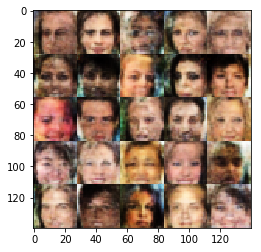

Epoch 6/6... Discriminator Loss: 1.3761... Generator Loss: 0.6687
Epoch 6/6... Discriminator Loss: 1.3608... Generator Loss: 0.9168
Epoch 6/6... Discriminator Loss: 1.2980... Generator Loss: 0.7796
Epoch 6/6... Discriminator Loss: 1.2943... Generator Loss: 0.9436
Epoch 6/6... Discriminator Loss: 1.3131... Generator Loss: 0.8198
Epoch 6/6... Discriminator Loss: 1.2715... Generator Loss: 0.8645
Epoch 6/6... Discriminator Loss: 1.3173... Generator Loss: 0.9220
Epoch 6/6... Discriminator Loss: 1.3110... Generator Loss: 0.7860
Epoch 6/6... Discriminator Loss: 1.3065... Generator Loss: 0.8082
Epoch 6/6... Discriminator Loss: 1.3338... Generator Loss: 0.9949
Epoch 6/6... Discriminator Loss: 1.3421... Generator Loss: 1.0520
Epoch 6/6... Discriminator Loss: 1.2318... Generator Loss: 0.9588
Epoch 6/6... Discriminator Loss: 1.2755... Generator Loss: 0.8059
Epoch 6/6... Discriminator Loss: 1.4397... Generator Loss: 1.0109
Epoch 6/6... Discriminator Loss: 1.1826... Generator Loss: 1.1327
Epoch 6/6.

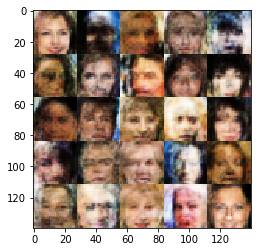

Epoch 6/6... Discriminator Loss: 1.2858... Generator Loss: 1.0161
Epoch 6/6... Discriminator Loss: 1.3787... Generator Loss: 0.7839
Epoch 6/6... Discriminator Loss: 1.3110... Generator Loss: 0.7927
Epoch 6/6... Discriminator Loss: 1.2529... Generator Loss: 0.7789
Epoch 6/6... Discriminator Loss: 1.3551... Generator Loss: 0.7616
Epoch 6/6... Discriminator Loss: 1.3428... Generator Loss: 0.7095
Epoch 6/6... Discriminator Loss: 1.2741... Generator Loss: 0.9002
Epoch 6/6... Discriminator Loss: 1.3573... Generator Loss: 0.7342
Epoch 6/6... Discriminator Loss: 1.2680... Generator Loss: 0.8462
Epoch 6/6... Discriminator Loss: 1.3572... Generator Loss: 0.8221
Epoch 6/6... Discriminator Loss: 1.2776... Generator Loss: 0.8945
Epoch 6/6... Discriminator Loss: 1.2014... Generator Loss: 0.8754
Epoch 6/6... Discriminator Loss: 1.3041... Generator Loss: 0.7225
Epoch 6/6... Discriminator Loss: 1.2733... Generator Loss: 0.8337
Epoch 6/6... Discriminator Loss: 1.2277... Generator Loss: 0.9546
Epoch 6/6.

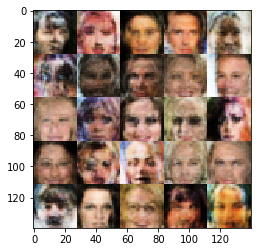

Epoch 6/6... Discriminator Loss: 1.2899... Generator Loss: 0.7205
Epoch 6/6... Discriminator Loss: 1.2644... Generator Loss: 0.7628
Epoch 6/6... Discriminator Loss: 1.2377... Generator Loss: 0.9680
Epoch 6/6... Discriminator Loss: 1.3287... Generator Loss: 0.8473
Epoch 6/6... Discriminator Loss: 1.3115... Generator Loss: 0.8907
Epoch 6/6... Discriminator Loss: 1.3563... Generator Loss: 0.9479
Epoch 6/6... Discriminator Loss: 1.2881... Generator Loss: 0.8654
Epoch 6/6... Discriminator Loss: 1.3449... Generator Loss: 0.9112
Epoch 6/6... Discriminator Loss: 1.3548... Generator Loss: 1.1770
Epoch 6/6... Discriminator Loss: 1.3407... Generator Loss: 0.7030
Epoch 6/6... Discriminator Loss: 1.3198... Generator Loss: 0.7928
Epoch 6/6... Discriminator Loss: 1.2854... Generator Loss: 0.7702
Epoch 6/6... Discriminator Loss: 1.3665... Generator Loss: 0.8569
Epoch 6/6... Discriminator Loss: 1.2428... Generator Loss: 0.7923
Epoch 6/6... Discriminator Loss: 1.2481... Generator Loss: 1.0006
Epoch 6/6.

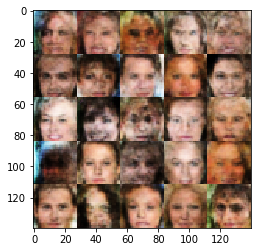

Epoch 6/6... Discriminator Loss: 1.2820... Generator Loss: 0.7952
Epoch 6/6... Discriminator Loss: 1.2173... Generator Loss: 0.7668
Epoch 6/6... Discriminator Loss: 1.3423... Generator Loss: 0.8157
Epoch 6/6... Discriminator Loss: 1.3158... Generator Loss: 0.8470
Epoch 6/6... Discriminator Loss: 1.2516... Generator Loss: 0.8501
Epoch 6/6... Discriminator Loss: 1.3070... Generator Loss: 0.8591
Epoch 6/6... Discriminator Loss: 1.2829... Generator Loss: 0.8388
Epoch 6/6... Discriminator Loss: 1.2472... Generator Loss: 0.9299
Epoch 6/6... Discriminator Loss: 1.3890... Generator Loss: 0.7106
Epoch 6/6... Discriminator Loss: 1.3934... Generator Loss: 0.7452
Epoch 6/6... Discriminator Loss: 1.3094... Generator Loss: 0.8686
Epoch 6/6... Discriminator Loss: 1.2685... Generator Loss: 1.0239
Epoch 6/6... Discriminator Loss: 1.2711... Generator Loss: 0.8011
Epoch 6/6... Discriminator Loss: 1.3386... Generator Loss: 0.8814
Epoch 6/6... Discriminator Loss: 1.2162... Generator Loss: 1.1670
Epoch 6/6.

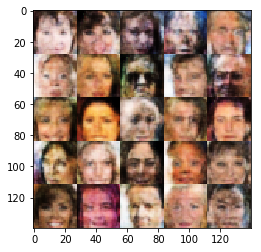

Epoch 6/6... Discriminator Loss: 1.3118... Generator Loss: 0.7119
Epoch 6/6... Discriminator Loss: 1.2973... Generator Loss: 0.8920
Epoch 6/6... Discriminator Loss: 1.4262... Generator Loss: 0.7019
Epoch 6/6... Discriminator Loss: 1.3791... Generator Loss: 0.7676
Epoch 6/6... Discriminator Loss: 1.3552... Generator Loss: 0.7852
Epoch 6/6... Discriminator Loss: 1.2098... Generator Loss: 0.9509
Epoch 6/6... Discriminator Loss: 1.3639... Generator Loss: 0.8130
Epoch 6/6... Discriminator Loss: 1.3799... Generator Loss: 0.8151
Epoch 6/6... Discriminator Loss: 1.3721... Generator Loss: 0.8771
Epoch 6/6... Discriminator Loss: 1.3703... Generator Loss: 1.2684
Epoch 6/6... Discriminator Loss: 1.2601... Generator Loss: 0.7094
Epoch 6/6... Discriminator Loss: 1.2573... Generator Loss: 1.0121
Epoch 6/6... Discriminator Loss: 1.3895... Generator Loss: 0.8365
Epoch 6/6... Discriminator Loss: 1.2251... Generator Loss: 0.9056
Epoch 6/6... Discriminator Loss: 1.2678... Generator Loss: 0.8608
Epoch 6/6.

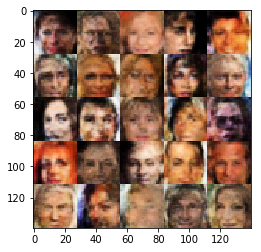

Epoch 6/6... Discriminator Loss: 1.3069... Generator Loss: 0.8628
Epoch 6/6... Discriminator Loss: 1.3159... Generator Loss: 1.1649
Epoch 6/6... Discriminator Loss: 1.3266... Generator Loss: 0.7349
Epoch 6/6... Discriminator Loss: 1.3351... Generator Loss: 0.7524
Epoch 6/6... Discriminator Loss: 1.3052... Generator Loss: 0.9046
Epoch 6/6... Discriminator Loss: 1.3397... Generator Loss: 0.9143
Epoch 6/6... Discriminator Loss: 1.3424... Generator Loss: 0.7396
Epoch 6/6... Discriminator Loss: 1.2869... Generator Loss: 0.8327
Epoch 6/6... Discriminator Loss: 1.2722... Generator Loss: 0.7739
Epoch 6/6... Discriminator Loss: 1.3455... Generator Loss: 0.7927
Epoch 6/6... Discriminator Loss: 1.3391... Generator Loss: 0.7389
Epoch 6/6... Discriminator Loss: 1.3410... Generator Loss: 0.9729
Epoch 6/6... Discriminator Loss: 1.3157... Generator Loss: 0.9164
Epoch 6/6... Discriminator Loss: 1.3135... Generator Loss: 0.9107
Epoch 6/6... Discriminator Loss: 1.3371... Generator Loss: 0.9005
Epoch 6/6.

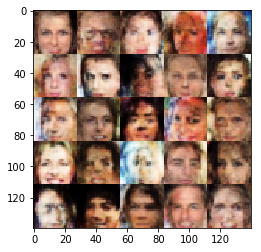

Epoch 6/6... Discriminator Loss: 1.2334... Generator Loss: 0.8625
Epoch 6/6... Discriminator Loss: 1.2868... Generator Loss: 0.8886
Epoch 6/6... Discriminator Loss: 1.3596... Generator Loss: 0.7371
Epoch 6/6... Discriminator Loss: 1.3003... Generator Loss: 0.8058
Epoch 6/6... Discriminator Loss: 1.2159... Generator Loss: 0.9948
Epoch 6/6... Discriminator Loss: 1.1013... Generator Loss: 1.5199
Epoch 6/6... Discriminator Loss: 1.2907... Generator Loss: 0.8616
Epoch 6/6... Discriminator Loss: 1.2242... Generator Loss: 1.0397
Epoch 6/6... Discriminator Loss: 1.3305... Generator Loss: 0.7567
Epoch 6/6... Discriminator Loss: 1.2970... Generator Loss: 0.9679
Epoch 6/6... Discriminator Loss: 1.2899... Generator Loss: 0.8070
Epoch 6/6... Discriminator Loss: 1.2881... Generator Loss: 0.7460
Epoch 6/6... Discriminator Loss: 1.4472... Generator Loss: 0.6008
Epoch 6/6... Discriminator Loss: 1.3245... Generator Loss: 1.0803
Epoch 6/6... Discriminator Loss: 1.2490... Generator Loss: 0.8913
Epoch 6/6.

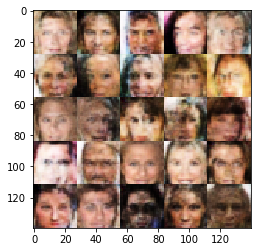

Epoch 6/6... Discriminator Loss: 1.3049... Generator Loss: 1.0632
Epoch 6/6... Discriminator Loss: 1.3488... Generator Loss: 0.7811
Epoch 6/6... Discriminator Loss: 1.2561... Generator Loss: 0.8611
Epoch 6/6... Discriminator Loss: 1.2826... Generator Loss: 0.8959
Epoch 6/6... Discriminator Loss: 1.3233... Generator Loss: 0.7604
Epoch 6/6... Discriminator Loss: 1.1759... Generator Loss: 1.0337
Epoch 6/6... Discriminator Loss: 1.2964... Generator Loss: 0.7873
Epoch 6/6... Discriminator Loss: 1.3213... Generator Loss: 0.8099
Epoch 6/6... Discriminator Loss: 1.3253... Generator Loss: 0.7682
Epoch 6/6... Discriminator Loss: 1.3369... Generator Loss: 0.8082
Epoch 6/6... Discriminator Loss: 1.3503... Generator Loss: 0.7332
Epoch 6/6... Discriminator Loss: 1.3326... Generator Loss: 0.7938
Epoch 6/6... Discriminator Loss: 1.2543... Generator Loss: 0.9816
Epoch 6/6... Discriminator Loss: 1.3405... Generator Loss: 0.8073
Epoch 6/6... Discriminator Loss: 1.3113... Generator Loss: 0.9689
Epoch 6/6.

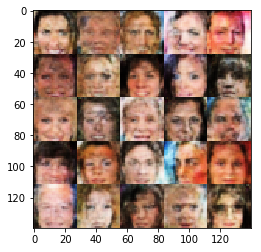

Epoch 6/6... Discriminator Loss: 1.3205... Generator Loss: 0.7966
Epoch 6/6... Discriminator Loss: 1.3027... Generator Loss: 0.7312
Epoch 6/6... Discriminator Loss: 1.2606... Generator Loss: 0.8300
Epoch 6/6... Discriminator Loss: 1.2630... Generator Loss: 0.9085
Epoch 6/6... Discriminator Loss: 1.2854... Generator Loss: 0.8064
Epoch 6/6... Discriminator Loss: 1.2555... Generator Loss: 0.8256
Epoch 6/6... Discriminator Loss: 1.3475... Generator Loss: 0.8987
Epoch 6/6... Discriminator Loss: 1.2434... Generator Loss: 0.8329
Epoch 6/6... Discriminator Loss: 1.2245... Generator Loss: 0.8634
Epoch 6/6... Discriminator Loss: 1.3412... Generator Loss: 0.6726
Epoch 6/6... Discriminator Loss: 1.1925... Generator Loss: 0.8932
Epoch 6/6... Discriminator Loss: 1.2549... Generator Loss: 0.9689
Epoch 6/6... Discriminator Loss: 1.3335... Generator Loss: 0.9358
Epoch 6/6... Discriminator Loss: 1.2290... Generator Loss: 0.9219
Epoch 6/6... Discriminator Loss: 1.3022... Generator Loss: 0.6976
Epoch 6/6.

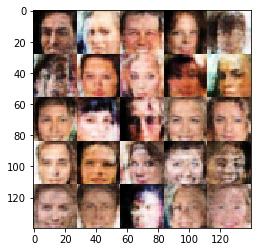

Epoch 6/6... Discriminator Loss: 1.3235... Generator Loss: 1.0605
Epoch 6/6... Discriminator Loss: 1.3265... Generator Loss: 0.7863
Epoch 6/6... Discriminator Loss: 1.2888... Generator Loss: 0.8071
Epoch 6/6... Discriminator Loss: 1.4150... Generator Loss: 0.7886
Epoch 6/6... Discriminator Loss: 1.3019... Generator Loss: 0.7890
Epoch 6/6... Discriminator Loss: 1.2479... Generator Loss: 0.8623
Epoch 6/6... Discriminator Loss: 1.2441... Generator Loss: 0.8708
Epoch 6/6... Discriminator Loss: 1.2966... Generator Loss: 0.8320
Epoch 6/6... Discriminator Loss: 1.2857... Generator Loss: 0.8834
Epoch 6/6... Discriminator Loss: 1.2863... Generator Loss: 0.8618
Epoch 6/6... Discriminator Loss: 1.2464... Generator Loss: 0.9064
Epoch 6/6... Discriminator Loss: 1.2747... Generator Loss: 0.9022
Epoch 6/6... Discriminator Loss: 1.2853... Generator Loss: 0.9013
Epoch 6/6... Discriminator Loss: 1.4071... Generator Loss: 0.7002
Epoch 6/6... Discriminator Loss: 1.3596... Generator Loss: 0.7564
Epoch 6/6.

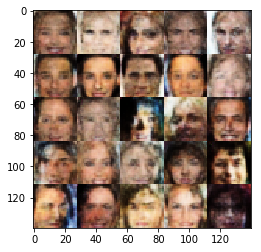

Epoch 6/6... Discriminator Loss: 1.2742... Generator Loss: 0.8670
Epoch 6/6... Discriminator Loss: 1.3220... Generator Loss: 0.7886
Epoch 6/6... Discriminator Loss: 1.3532... Generator Loss: 0.8440
Epoch 6/6... Discriminator Loss: 1.2764... Generator Loss: 0.9148
Epoch 6/6... Discriminator Loss: 1.2530... Generator Loss: 0.8722
Epoch 6/6... Discriminator Loss: 1.4270... Generator Loss: 0.7273
Epoch 6/6... Discriminator Loss: 1.2749... Generator Loss: 0.9260
Epoch 6/6... Discriminator Loss: 1.3637... Generator Loss: 0.8086
Epoch 6/6... Discriminator Loss: 1.3133... Generator Loss: 0.7544
Epoch 6/6... Discriminator Loss: 1.3861... Generator Loss: 0.9492
Epoch 6/6... Discriminator Loss: 1.2829... Generator Loss: 0.9356
Epoch 6/6... Discriminator Loss: 1.3388... Generator Loss: 0.9131
Epoch 6/6... Discriminator Loss: 1.3460... Generator Loss: 0.7673
Epoch 6/6... Discriminator Loss: 1.2107... Generator Loss: 0.9323
Epoch 6/6... Discriminator Loss: 1.3507... Generator Loss: 0.7906
Epoch 6/6.

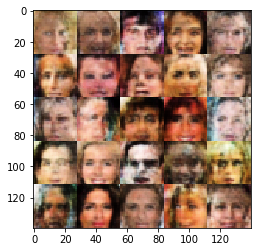

Epoch 6/6... Discriminator Loss: 1.3509... Generator Loss: 0.7822
Epoch 6/6... Discriminator Loss: 1.3670... Generator Loss: 0.7845
Epoch 6/6... Discriminator Loss: 1.3781... Generator Loss: 0.7135
Epoch 6/6... Discriminator Loss: 1.3180... Generator Loss: 0.6899
Epoch 6/6... Discriminator Loss: 1.4279... Generator Loss: 0.5954
Epoch 6/6... Discriminator Loss: 1.3267... Generator Loss: 0.8144
Epoch 6/6... Discriminator Loss: 1.3430... Generator Loss: 0.9377
Epoch 6/6... Discriminator Loss: 1.2921... Generator Loss: 0.8210
Epoch 6/6... Discriminator Loss: 1.2877... Generator Loss: 0.8685
Epoch 6/6... Discriminator Loss: 1.3072... Generator Loss: 0.9135
Epoch 6/6... Discriminator Loss: 1.3164... Generator Loss: 0.9140
Epoch 6/6... Discriminator Loss: 1.2820... Generator Loss: 0.7827
Epoch 6/6... Discriminator Loss: 1.2621... Generator Loss: 0.9081
Epoch 6/6... Discriminator Loss: 1.2918... Generator Loss: 0.7871
Epoch 6/6... Discriminator Loss: 1.3376... Generator Loss: 0.7577
Epoch 6/6.

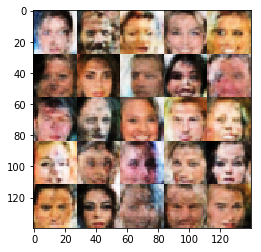

Epoch 6/6... Discriminator Loss: 1.3551... Generator Loss: 0.8554
Epoch 6/6... Discriminator Loss: 1.2474... Generator Loss: 0.8647
Epoch 6/6... Discriminator Loss: 1.3180... Generator Loss: 0.8057
Epoch 6/6... Discriminator Loss: 1.3772... Generator Loss: 0.7738
Epoch 6/6... Discriminator Loss: 1.4867... Generator Loss: 0.6538
Epoch 6/6... Discriminator Loss: 1.3021... Generator Loss: 0.8332
Epoch 6/6... Discriminator Loss: 1.3748... Generator Loss: 0.5871
Epoch 6/6... Discriminator Loss: 1.2266... Generator Loss: 0.7907
Epoch 6/6... Discriminator Loss: 1.3844... Generator Loss: 0.7564
Epoch 6/6... Discriminator Loss: 1.2967... Generator Loss: 0.7982
Epoch 6/6... Discriminator Loss: 1.2593... Generator Loss: 0.9415
Epoch 6/6... Discriminator Loss: 1.3445... Generator Loss: 0.7326
Epoch 6/6... Discriminator Loss: 1.3174... Generator Loss: 0.9197
Epoch 6/6... Discriminator Loss: 1.2686... Generator Loss: 0.9749
Epoch 6/6... Discriminator Loss: 1.3230... Generator Loss: 0.9040
Epoch 6/6.

In [22]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 6

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.